## Figure 4 Code to Produce Figures

This figure will focus on the presentation of Further Analysis of Extracted Assemblies.

In [2]:
# importing packages

import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import squareform, pdist
import scipy.io
from scipy import stats
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from difflib import diff_bytes
import seaborn as sns
import h5py
import scipy
import os
import upsetplot
import ptitprince
import matplotlib.cm as cm
from tqdm import tqdm
plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (10,10)

import v1dd_physiology.data_fetching as daf
from statannotations.Annotator import Annotator

from matplotlib.colors import LinearSegmentedColormap

paired_blue0 = cm.get_cmap('Paired')(0)
paired_blue1 = cm.get_cmap('Paired')(1)

colors1 = ['grey', (.4, .6, .8, .5)]
colors2 = ['grey', (.2, .3, .5, .5), (.4, .6, .8, .5), 'white']
colors3 = [(.2, .3, .5, .5), 'white']
colors4 = ['grey', (.2, .3, .5, .5), (.4, .6, .8, .5),]
colors5 = [(.2, .3, .5, .5), (.4, .6, .8, .5), 'white']
colors6 = ['grey', 'steelblue', (.4, .6, .8, .5),]
colors7 = ['grey', 'steelblue']
colors8 = ['grey', 'cornflowerblue']
colors9 = ['grey', paired_blue1]
colors10 = ['dimgrey', paired_blue0]
greymap = LinearSegmentedColormap.from_list(
        "Custom", colors10, N=80) 

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Oracle Scores Assemblies

In [4]:
### Functions relevant for Oracle Score Analysis

def distance(x, y):
    return math.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

# def process(img):
#     img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img_canny = cv2.Canny(img_gray, 0, 50)
#     img_dilate = cv2.dilate(img_canny, None, iterations=1)
#     img_erode = cv2.erode(img_dilate, None, iterations=1)
#     return img_erode

def get_assembly_time_trace(coactivity_trace, scores_in_order, name='scored_time_trace'):
    # Set up three subplots
    num_assemblies = coactivity_trace.shape[1]
    fig, ax = plt.subplots(num_assemblies, 1, figsize=(12, 12))

    # plot
    for i in range(num_assemblies):
        ax[i].plot(coactivity_trace[:, i], color=(.2, .3, .5, .5))
        ax[i].set_ylabel(f"{scores_in_order[i]:.2}")
        ax[i].set_xlabel("Time Steps")
        ax[i].grid()

    fig.suptitle("Assembly Time Trace")
    #plt.savefig(f"oracle_dists2/assemblies_esteps_150000_affinity_04_{name}.png", dpi = 1200)

Assembly Lengths
[1016, 542, 328, 325, 230, 188, 187, 181, 121, 114, 112, 61, 48, 35, 23]
Random Ensemble Lengths
[1016, 542, 328, 325, 230, 188, 187, 181, 121, 114, 112, 61, 48, 35, 23]


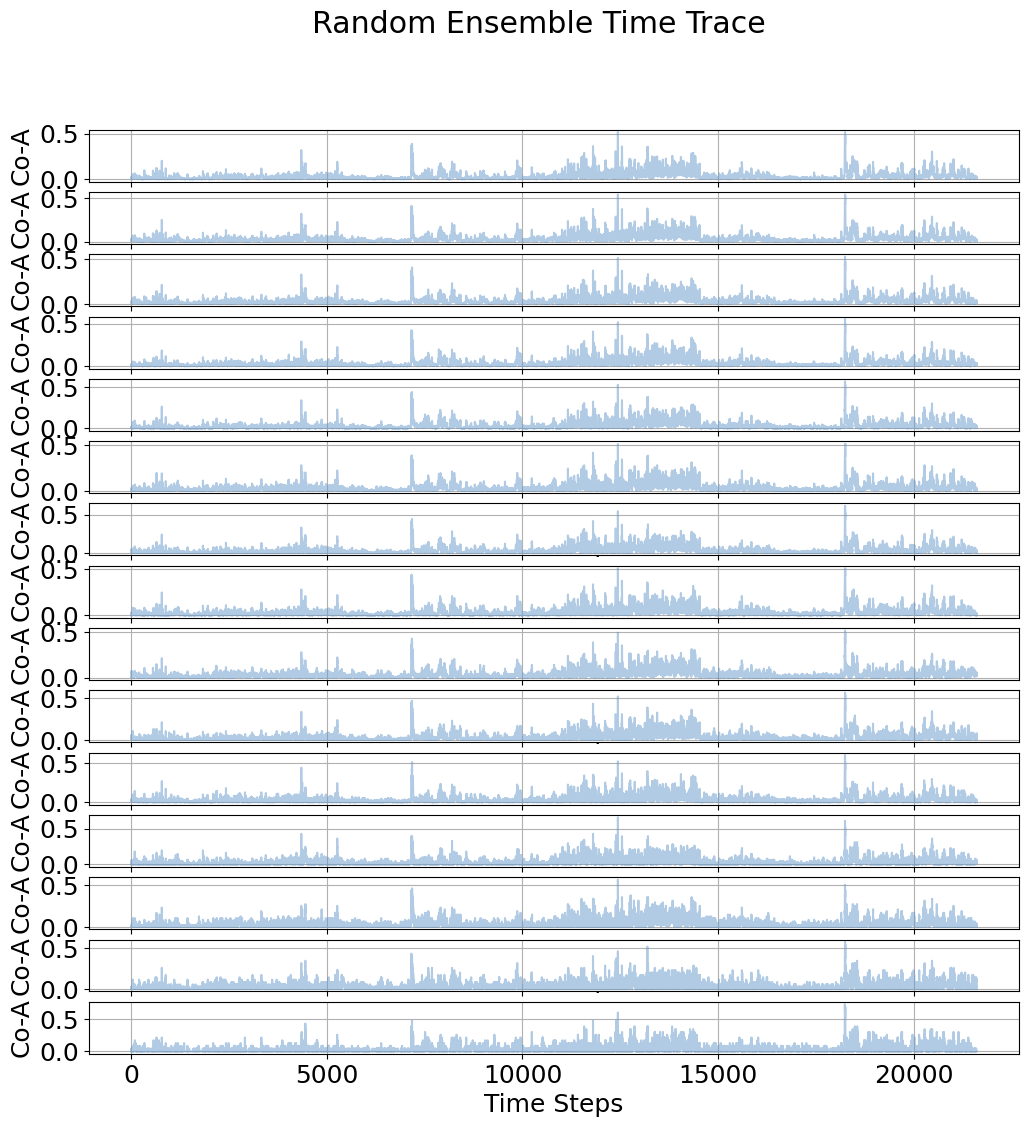

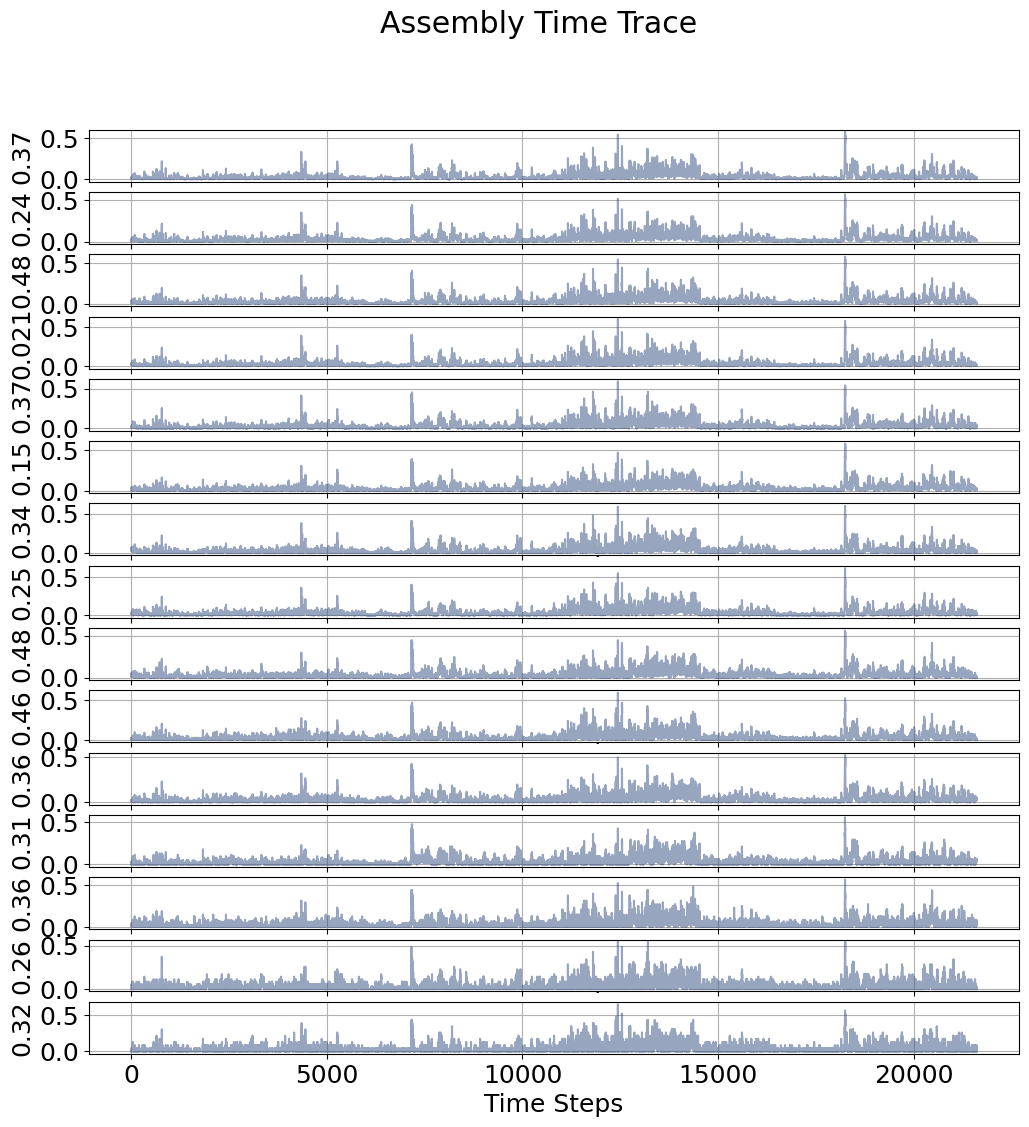

In [5]:
### STEP 1: Produce 'random_ensembles': Random Collections of Neurons that are same sizes as the assemblies. 

### Set the seed for reproducability, outside of the loop.
random.seed(47)
np.random.seed(47)

### Overlap is fine so we don't have to worry about that.
SGC_ASSEMBLIES = scipy.io.loadmat(
    "../Data/Session13/Assembly_Files/esteps_150000_affinity_04_sessionM409828_13_SGC-ASSEMBLIES.mat", struct_as_record=True, squeeze_me=True)
assemblies = SGC_ASSEMBLIES['assemblies']

dF_trace = np.load("../Data/Session13/sessionM409828_13_CALCIUM-FLUORESCENCE.npy")
num_neurons = dF_trace.shape[1]

random_ensembles = []
for A in assemblies:
    curr_length = len(A)
    # get random ids, make sure there are no repeats in the ids for that specific ensemble
    random_ensembles.append(np.sort(np.array(random.sample(range(num_neurons), curr_length))))

# Order the random ensembles by size
random_ensembles.sort(key = len)
random_ensembles.reverse()

# %%
with open('random_ensembles.pkl', 'wb') as f:
    pickle.dump(random_ensembles, f)
random_ensembles

# %%

print("Assembly Lengths")
assemblies = [np.array(A) - 1 for A in assemblies]
assemblies.sort(key = len)
assemblies.reverse()
print([len(A) for A in assemblies])

print("Random Ensemble Lengths")
print([len(r) for r in random_ensembles])

# %%
### STEP 2: Use the raster plots produced by SGC
### STEP 3: Produce a co-activity trace of each random_ensemble
ACTIVITY_RASTER = scipy.io.loadmat(
    "../Data/Session13/Assembly_Files/esteps_150000_affinity_04_sessionM409828_13_ACTIVITY-RASTER.mat", struct_as_record=True, squeeze_me=True)

activity_raster = ACTIVITY_RASTER['activity_raster']
#activity_raster_peaks = ACTIVITY_RASTER['activity_raster_peaks']

coactivity_trace = activity_raster.mean(axis=1)

# Assembly Coactivity Trace
assembly_coactivity_trace = np.vstack(
    [activity_raster[:, A-1].mean(axis=1) for A in assemblies]).T

# Random Ensemble Coactivity Trace
random_ensembles_coactivity_trace = np.vstack(
    [activity_raster[:, A-1].mean(axis=1) for A in random_ensembles]).T

# %%
def get_ensemble_time_trace(coactivity_trace, title):
    # Set up three subplots
    num_assemblies = coactivity_trace.shape[1]
    fig, ax = plt.subplots(num_assemblies, 1, figsize=(12, 12))

    # plot
    for i in range(num_assemblies):
        ax[i].plot(coactivity_trace[:, i], color=(.4, .6, .8, .5))
        ax[i].set_ylabel("Co-A")
        ax[i].set_xlabel("Time Steps")
        ax[i].grid()

    fig.suptitle(title)
    #plt.savefig(f"oracle_dists2/assemblies_esteps_150000_affinity_04_{name}.png", dpi = 1200)

# %%
### Plot the random ensemble coactivity traces in order
get_ensemble_time_trace(random_ensembles_coactivity_trace, title = "Random Ensemble Time Trace")
scores_in_order = np.load('oracle_dists/assemblies_esteps_150000_affinity_04_session13_natural_movie_oracle_scores.npy')
get_assembly_time_trace(assembly_coactivity_trace, scores_in_order)

In [6]:
print(SGC_ASSEMBLIES.keys())

dict_keys(['__header__', '__version__', '__globals__', 'assembly_pattern_detection', 'assemblies'])


In [7]:
nwb_f = h5py.File('M409828_13_20181213.nwb', 'r')
import v1dd_physiology.data_fetching as daf

sess_id = daf.get_session_id(nwb_f=nwb_f)
print(sess_id)

# plane_ns = daf.get_plane_names(nwb_f=nwb_f)
# print("Planes: ", plane_ns)

# for plane_n in plane_ns:
#     depth = daf.get_plane_depth(nwb_f=nwb_f, plane_n=plane_n)
#     print(f'depth of {plane_n}: {depth} um')

fs = []
dffs = []
events = []
locomotions = []
rois = []
pika_rois = []
coords = []

# Uncomment this if you want the actual fluorescence activity trace
# f = np.array(nwb_f['processing']['rois_and_traces_plane0']
#              ['Fluorescence']['f_raw_subtracted'].get('data'))

# If you want DFF, you need to compute it using the allensdk, or load saved traces from /home/berteau/v1DD

f = assembly_coactivity_trace
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))
# events
clip_ts = f.shape[1]

total_movie_oracle_r_values = np.zeros((0, 9))

passing_roi_count = f.shape[1]

oracle_r_values = np.zeros((passing_roi_count, 25, 8))
movie_oracle_r_values = np.zeros((passing_roi_count, 9))

M409828_13


/tmp/ipykernel_950887/3932925097.py:30: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']


In [8]:
plane_ns = daf.get_plane_names(nwb_f=nwb_f)
plane_ns
rois_dict = {}
for plane_n in plane_ns:
    roi_ns = daf.get_roi_ns(nwb_f=nwb_f, plane_n=plane_n)
    print(f'there are {len(roi_ns)} in {plane_n} of session: {sess_id}:')
    print('\nnames of first 100 rois:\n')
    print(roi_ns[0:100])
    rois_dict[plane_n] = roi_ns

there are 1234 in plane0 of session: M409828_13:

names of first 100 rois:

['roi_0000', 'roi_0001', 'roi_0002', 'roi_0003', 'roi_0004', 'roi_0005', 'roi_0006', 'roi_0007', 'roi_0008', 'roi_0009', 'roi_0010', 'roi_0011', 'roi_0012', 'roi_0013', 'roi_0014', 'roi_0015', 'roi_0016', 'roi_0017', 'roi_0018', 'roi_0019', 'roi_0020', 'roi_0021', 'roi_0022', 'roi_0023', 'roi_0024', 'roi_0025', 'roi_0026', 'roi_0027', 'roi_0028', 'roi_0029', 'roi_0030', 'roi_0031', 'roi_0032', 'roi_0033', 'roi_0034', 'roi_0035', 'roi_0036', 'roi_0037', 'roi_0038', 'roi_0039', 'roi_0040', 'roi_0041', 'roi_0042', 'roi_0043', 'roi_0044', 'roi_0045', 'roi_0046', 'roi_0047', 'roi_0048', 'roi_0049', 'roi_0050', 'roi_0051', 'roi_0052', 'roi_0053', 'roi_0054', 'roi_0055', 'roi_0056', 'roi_0057', 'roi_0058', 'roi_0059', 'roi_0060', 'roi_0061', 'roi_0062', 'roi_0063', 'roi_0064', 'roi_0065', 'roi_0066', 'roi_0067', 'roi_0068', 'roi_0069', 'roi_0070', 'roi_0071', 'roi_0072', 'roi_0073', 'roi_0074', 'roi_0075', 'roi_0076',

In [9]:
assembly_neurons = set()
for assembly in assemblies:
    print(np.min(assembly))
    assembly_neurons.update(set(assembly))
assembly_neurons = np.array(list(assembly_neurons))
len(assembly_neurons)
no_assembly_neurons = set()
for i in range(num_neurons):
    if i not in assembly_neurons:
        no_assembly_neurons.add(i)

11
13
32
48
11
5
56
17
19
9
0
16
211
64
79


## Oracle Scores

/tmp/ipykernel_950887/2207110318.py:54: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_timestamps = np.array(
/tmp/ipykernel_950887/2207110318.py:56: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_data = np.array(presentation['natural_movie'].get('data'))
/home/berteau/anaconda3/envs/allensdk/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_950887/2207110318.py:75: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
/tmp/ipykernel_950887/2207110318.py:82: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and 

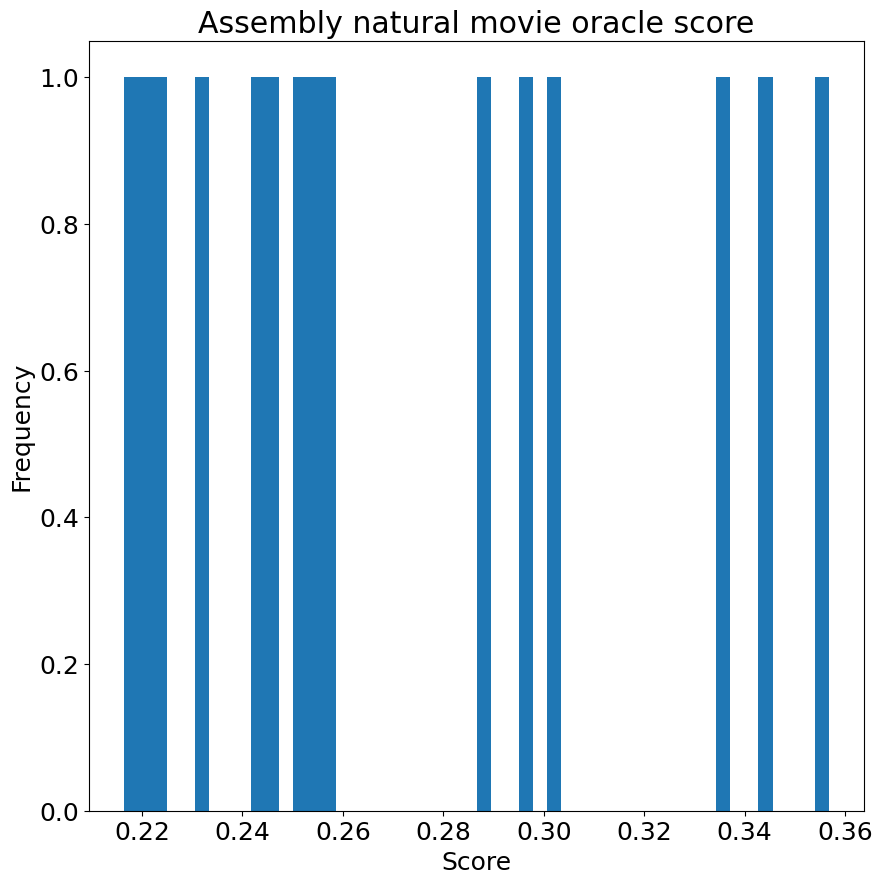

/tmp/ipykernel_950887/2207110318.py:113: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
/tmp/ipykernel_950887/2207110318.py:120: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_timestamps = np.array(
/tmp/ipykernel_950887/2207110318.py:122: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_data = np.array(presentation['natural_movie'].get('data'))


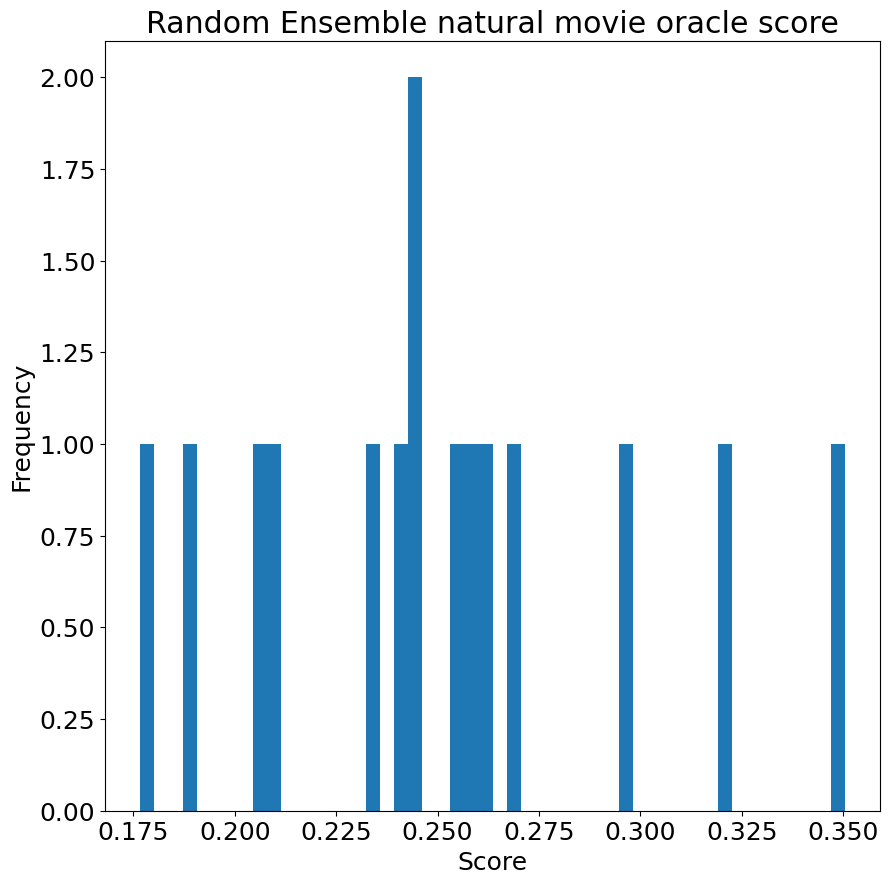

<Figure size 1000x700 with 0 Axes>

In [10]:
pika_rois_all_dict = {}
pika_rois_in_assembly_dict = {}
pika_rois_no_assembly_dict = {}
for plane_n, roi_ns in rois_dict.items():
    pika_rois = []
    pika_rois_in_assembly = []
    pika_rois_no_assembly = []
    # print(plane_n)
    for roi_n in roi_ns:
        score = daf.get_pika_classifier_score(nwb_f=nwb_f, plane_n=plane_n, roi_n=roi_n)
        if score > 0.5:  # Using the threshold from team PIKA, per https://github.com/zhuangjun1981/v1dd_physiology/blob/main/v1dd_physiology/example_notebooks/2022-06-27-data-fetching-basic.ipynb
            pika_rois.append(roi_n)
            if int(roi_n[4:]) in assembly_neurons:
                pika_rois_in_assembly.append(roi_n)
            else:
                pika_rois_no_assembly.append(roi_n)
    pika_rois_all_dict[plane_n] = pika_rois
    pika_rois_in_assembly_dict[plane_n] = pika_rois_in_assembly
    pika_rois_no_assembly_dict[plane_n] = pika_rois_no_assembly

total_rois = np.sum([len(val) for val in pika_rois_all_dict.values()])
neuron_all_movie_oracle_r_values = np.zeros((total_rois, 9))

total_rois = np.sum([len(val) for val in pika_rois_in_assembly_dict.values()])
neuron_in_assembly_movie_oracle_r_values = np.zeros((total_rois, 9))

total_rois = np.sum([len(val) for val in pika_rois_no_assembly_dict.values()])
neuron_no_assembly_movie_oracle_r_values = np.zeros((total_rois, 9))

count_n_all = -1
count_n_in_assembly = -1
count_n_no_assembly = -1
for curr_dict, oracle_array, c in zip([pika_rois_all_dict, pika_rois_in_assembly_dict, pika_rois_no_assembly_dict], 
        [neuron_all_movie_oracle_r_values, neuron_in_assembly_movie_oracle_r_values, neuron_no_assembly_movie_oracle_r_values],
        [1,2,3]):
    for plane_n, pika_roi_ns in curr_dict.items():
        for roi_n in pika_roi_ns:
            if c == 1:
                count_n_all += 1
                current_count = count_n_all
            elif c == 2:
                count_n_in_assembly += 1
                current_count = count_n_in_assembly
            elif c == 3:
                count_n_no_assembly += 1
                current_count = count_n_no_assembly
            ### Get Time Trace
            dff, dff_ts = daf.get_single_trace(nwb_f=nwb_f, plane_n=plane_n, roi_n=roi_n, trace_type='dff')
            f_binary_raster = activity_raster[:, int(roi_n[4:])-1]
            
            # Get Repeated Natural Movies
            trial_fluorescence = []
            presentation = nwb_f['stimulus']['presentation']
            nm_timestamps = np.array(
                presentation['natural_movie'].get('timestamps'))
            nm_data = np.array(presentation['natural_movie'].get('data'))
            new_clips = np.where(nm_data[:, 2] == 0)[0]
            clip_duration = 300  # new_clips[1]-1
            for repeat_id in range(new_clips.shape[0]):
                frames_to_capture = np.where(dff_ts >= nm_timestamps[new_clips[repeat_id]])[
                    0][0:clip_duration]
                trial_fluorescence.append(f_binary_raster[frames_to_capture])
            trial_fluorescence_np = np.array(trial_fluorescence)
            for trial_idx in range(trial_fluorescence_np.shape[0]):
                removed_trial = trial_fluorescence_np[trial_idx]
                remaining_trials = np.delete(
                    trial_fluorescence_np, trial_idx, 0)
                r, p = scipy.stats.pearsonr(
                    removed_trial, np.mean(remaining_trials, 0))
                oracle_array[current_count, trial_idx] = r

assembly_movie_oracle_r_values = np.zeros((passing_roi_count, 9))
f = assembly_coactivity_trace
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))
for roi_n in range(passing_roi_count):

    # Get Repeated Natural Movies
    trial_fluorescence = []
    presentation = nwb_f['stimulus']['presentation']
    nm_timestamps = np.array(
        presentation['natural_movie'].get('timestamps'))
    nm_data = np.array(presentation['natural_movie'].get('data'))
    new_clips = np.where(nm_data[:, 2] == 0)[0]
    clip_duration = 300  # new_clips[1]-1
    for repeat_id in range(new_clips.shape[0]):
        frames_to_capture = np.where(f_ts >= nm_timestamps[new_clips[repeat_id]])[
            0][0:clip_duration]
        trial_fluorescence.append(f[frames_to_capture, roi_n])
    trial_fluorescence_np = np.array(trial_fluorescence)
    for trial_idx in range(trial_fluorescence_np.shape[0]):
        removed_trial = trial_fluorescence_np[trial_idx]
        remaining_trials = np.delete(
            trial_fluorescence_np, trial_idx, 0)
        r, p = scipy.stats.pearsonr(
            removed_trial, np.mean(remaining_trials, 0))
        assembly_movie_oracle_r_values[roi_n, trial_idx] = r

# Plot Movie Oracles
mean_over_holdouts = np.mean(assembly_movie_oracle_r_values, 1)
fig = plt.figure()
plt.title('Assembly natural movie oracle score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.hist(mean_over_holdouts[:], bins=50)
#plt.savefig('./figure4_plots/oracle_dists2/assemblies_esteps_150000__affinity_04_session'+str(13)+'_movies.png')
plt.show()

random_ensemble_movie_oracle_r_values = np.zeros((passing_roi_count, 9))
f = random_ensembles_coactivity_trace
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))
for roi_n in range(passing_roi_count):

    # Get Repeated Natural Movies
    trial_fluorescence = []
    presentation = nwb_f['stimulus']['presentation']
    nm_timestamps = np.array(
        presentation['natural_movie'].get('timestamps'))
    nm_data = np.array(presentation['natural_movie'].get('data'))
    new_clips = np.where(nm_data[:, 2] == 0)[0]
    clip_duration = 300  # new_clips[1]-1
    for repeat_id in range(new_clips.shape[0]):
        frames_to_capture = np.where(f_ts >= nm_timestamps[new_clips[repeat_id]])[
            0][0:clip_duration]
        trial_fluorescence.append(f[frames_to_capture, roi_n])
    trial_fluorescence_np = np.array(trial_fluorescence)
    for trial_idx in range(trial_fluorescence_np.shape[0]):
        removed_trial = trial_fluorescence_np[trial_idx]
        remaining_trials = np.delete(
            trial_fluorescence_np, trial_idx, 0)
        r, p = scipy.stats.pearsonr(
            removed_trial, np.mean(remaining_trials, 0))
        random_ensemble_movie_oracle_r_values[roi_n, trial_idx] = r



import ptitprince as pt
# Plot Movie Oracles
mean_over_holdouts = np.mean(random_ensemble_movie_oracle_r_values, 1)
fig = plt.figure()
plt.title('Random Ensemble natural movie oracle score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.hist(mean_over_holdouts[:], bins=50)
#plt.savefig('./figure4_plots/oracle_dists2/assemblies_esteps_150000__affinity_04_session'+str(13)+'_movies.png')
plt.show()

# Create a figure
plt.figure(figsize=(10,7))
sns.set_theme(style="whitegrid")

all_arr = [np.array(assembly_movie_oracle_r_values).flatten(),
            np.array(random_ensemble_movie_oracle_r_values).flatten(),
            np.array(neuron_all_movie_oracle_r_values).flatten(),
            np.array(neuron_in_assembly_movie_oracle_r_values).flatten(),
            np.array(neuron_no_assembly_movie_oracle_r_values).flatten()]

# Prepare data for raincloud plot
data = pd.DataFrame({
    "Values": np.concatenate(all_arr),
    "Group": [f"Assemblies"] * len(assembly_movie_oracle_r_values.flatten()) + \
                [f"Random\nEnsembles"] * len(random_ensemble_movie_oracle_r_values.flatten()) + \
                [f"All\nCells"] * len(neuron_all_movie_oracle_r_values.flatten()) + \
                [f"Assembly\nCells"] * len(neuron_in_assembly_movie_oracle_r_values.flatten()) + \
                [f"Non-Assembly\nCells"] * len(neuron_no_assembly_movie_oracle_r_values.flatten())
})


p-value for Assemblies greater than Random
Ensembles: 0.209
p-value for Assemblies greater than All
Cells: 4.36e-19
p-value for Assemblies greater than Assembly
Cells: 5.99e-19
p-value for Assemblies greater than Non-Assembly
Cells: 4.69e-19


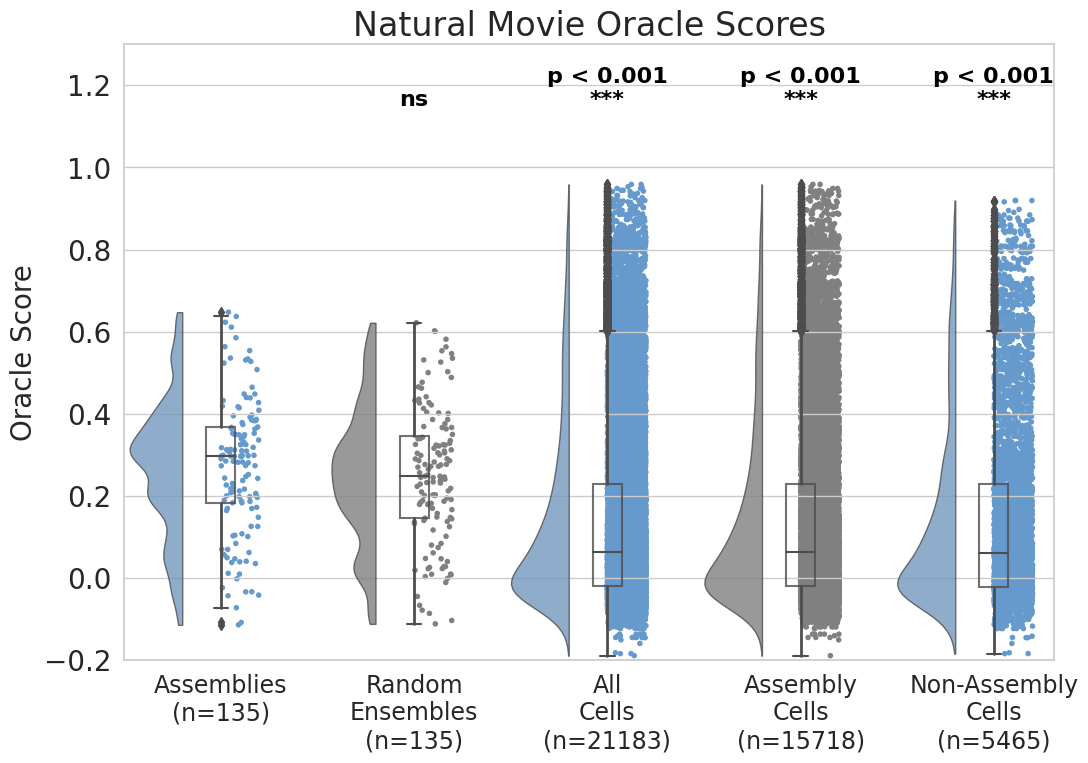

In [11]:
# Plot Oracle Scores
plt.figure(figsize=(12, 8))
# Create the raincloud plot
ax = pt.RainCloud(
    y="Values",
    x="Group",
    data=data,
    palette=[(.4, .6, .8, .5), 'grey'],
    width_viol=0.6,  # Adjust violin width
    alpha=0.8,  # Transparency of the cloud
    move=0.1,  # Adjust position of violins
    point_size = 4,
    orient="v"  # Horizontal orientation
)

plt.ylim(-0.2, 1.3)

# Calculate p-values for Wilcoxon rank-sum tests
groups = [f"Random\nEnsembles", "All\nCells", "Assembly\nCells", "Non-Assembly\nCells"]
group_labels = []
p_values = []
a_values = data[data["Group"] == "Assemblies"]["Values"]
a_values = a_values[~np.isnan(a_values)]
group_labels.append(f"Assemblies\n(n={len(a_values)})")
for group in groups:
    if group == "Assemblies":
        continue
    # print(group, group.type())
    group_values = data[data["Group"] == group]["Values"]
    group_values = group_values[~np.isnan(group_values)]
    group_labels.append(group + f"\n(n={len(group_values)})")
    p_value = stats.ranksums(a_values, group_values, alternative='two-sided').pvalue
    print(f"p-value for Assemblies greater than {group}: {p_value:.3g}")
    p_values.append(p_value)

# Add significance markers as number of asterisks
for i, p_value in enumerate(p_values):
    if p_value < 0.001:
        significance = 'p < 0.001\n***'
    elif p_value < 0.01:
        significance = 'p < 0.01\n**'
    elif p_value < 0.05:
        significance = 'p < 0.05\n*'
    else:
        significance = 'ns'
    ax.annotate(significance, xy=(i + 1,  1.15), #data[data["Group"] == groups[i]]["Values"].max()
                horizontalalignment='center', size=16, color='black', weight='bold')

# Add a multiline title to include the p-value, add y_label
title = f'Natural Movie Oracle Scores'
plt.title(title, size=24)
# plt.xlabel('Cell Grouping', size=20)
# plt.xticks(fontsize=20)  # Adjust size of xticks
plt.yticks(fontsize=20)  # Adjust size of yticks
plt.gca().set_xticklabels(group_labels, ha='center', fontsize=17)  # Adjust size of xtick labels
plt.ylabel("Oracle Score", size=20)
plt.xlabel(None)
# plt.tight_layout()
plt.savefig('./figure4_plots/oracle_scores_dff_all_sets_raincloud.png', dpi = 1200)
plt.savefig('./figure4_plots/oracle_scores_dff_all_sets_raincloud.pdf')
plt.savefig('./figure4_plots/oracle_scores_dff_all_sets_raincloud.svg')
plt.show()


### Sparsity Analysis

In [12]:
def get_assembly_time_trace(coactivity_trace):
    # Set up subplots
    num_assemblies = coactivity_trace.shape[1]
    fig, ax = plt.subplots(num_assemblies, 1, figsize=(12, 12))

    # plot
    for i in range(num_assemblies):
        ax[i].plot(coactivity_trace[:, i], color='green')
        ax[i].set_ylabel("A_{}".format(i+1))
        ax[i].set_xlabel("Time Steps")
        ax[i].grid()

    fig.suptitle("Assembly Time Trace")
    plt.savefig("stefan_time_trace.png")

def gini(x):
    """
    Calculate the Gini coefficient for a NumPy array of values.

    Args:
        x (numpy.ndarray): 1D array of values.

    Returns:
        float: Gini coefficient (ranging from 0 to 1).
    """

    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x) ** 2 * np.mean(x))

def plot_ginis(coactivity_trace, null_trace=None, all_trace=None, a_trace=None, no_a_trace=None):
    num_assemblies = coactivity_trace.shape[1]
    gini_values = [gini(coactivity_trace[:,i]) for i in range(num_assemblies)]
    labels = [f'A {i+1}' for i in range(num_assemblies)]
    
    if no_a_trace is not None:
        gini_values_no_a = [gini(no_a_trace[:,i]) for i in range(no_a_trace.shape[1])]
        mean_gini_no_a = np.nanmean(gini_values_no_a)
        # labels.insert(0, 'Nonassembly\nCells')
    
    if a_trace is not None:
        gini_values_a = [gini(a_trace[:,i]) for i in range(a_trace.shape[1])]
        mean_gini_a = np.nanmean(gini_values_a)
        # labels.insert(0, 'Assembly\nCells')
    
    if null_trace is not None:
        gini_values_null = [gini(null_trace[:,i]) for i in range(num_assemblies)]
        mean_gini_null = np.nanmean(gini_values_null)
        # labels.insert(0, 'Null')
        
    print(gini_values)
    print(gini_values_null)
    print(labels)

    # Create a DataFrame for the grouped bar plot
    gini_df = pd.DataFrame({
        'Assembly Gini Values': gini_values,
        'Random Ensemble Gini Values': gini_values_null,
        'Labels': labels
    })

    # print(gini_df)

    # Melt the DataFrame to long format
    gini_df_melted = gini_df.melt(id_vars='Labels', value_vars=['Assembly Gini Values', 'Random Ensemble Gini Values'], 
                                  var_name='Type', value_name='Gini Coefficient')

    p_value = stats.ranksums(np.array(gini_values_null).flatten(), np.array(gini_values).flatten(), alternative='two-sided').pvalue

    # Create a grouped bar plot
    plt.figure(figsize=(14, 10))
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x='Labels', y='Gini Coefficient', hue='Type', data=gini_df_melted, palette='Paired')
    ax.set_title(f'Sparsity of Activity\np={p_value:0.4g}', size=24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20, rotation=45)    
    ax.set_ylabel('Gini Coefficient', size=24)
    ax.set_xlabel('Assembly or Matched Random Ensemble', size=24)
    plt.ylim((0, 1.0))

    # Add horizontal lines for mean_gini_a and mean_gini_no_a
    if a_trace is not None:
        ax.axhline(mean_gini_a, color='cornflowerblue', linestyle='--', linewidth=2)
        ax.text(len(labels)-5.75, mean_gini_a-0.04, f'Assembly Cells Mean: {mean_gini_a:.3f}', 
                color='cornflowerblue', ha='left', va='bottom', fontsize=16, weight='bold')

    if no_a_trace is not None:
        ax.axhline(mean_gini_no_a, color='slategray', linestyle='--', linewidth=2)
        ax.text(len(labels)-5.75, mean_gini_no_a, f'Nonassembly Cells Mean: {mean_gini_no_a:.3f}', 
                color='slategray', ha='left', va='bottom', fontsize=16, weight='bold')

    # Add annotations for clarity (optional)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 30.5), textcoords='offset points', size=18, weight='bold', rotation=90)

    plt.legend(bbox_to_anchor=(0, 0.95), loc='upper left', frameon=True, fontsize=16)
    # plt.legend(, loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.savefig('./figure4_plots/sparsity_with_Gini_coefficient_by_assembly_and_random_ensembles.png')
    plt.savefig('./figure4_plots/sparsity_with_Gini_coefficient_by_assembly_and_random_ensembles.pdf')
    plt.savefig('./figure4_plots/sparsity_with_Gini_coefficient_by_assembly_and_random_ensembles.svg')


In [13]:
with open('../Figure3/map_ordered_to_sgc_output.pickle', 'rb') as f:
    map_ordered_to_sgc_output = pickle.load(f)
map_ordered_to_sgc_output

{1: 8,
 2: 9,
 3: 1,
 4: 12,
 5: 14,
 6: 10,
 7: 13,
 8: 15,
 9: 6,
 10: 3,
 11: 11,
 12: 5,
 13: 2,
 14: 4,
 15: 7}

In [14]:
ACTIVITY_RASTER = scipy.io.loadmat(
    "../Data/Session13/Assembly_Files/esteps_150000_affinity_04_sessionM409828_13_ACTIVITY-RASTER.mat", struct_as_record=True, squeeze_me=True)
SGC_ASSEMBLIES = scipy.io.loadmat(
    "../Data/Session13/Assembly_Files/esteps_150000_affinity_04_sessionM409828_13_SGC-ASSEMBLIES.mat", struct_as_record=True, squeeze_me=True)

#print(ACTIVITY_RASTER.keys())

activity_raster = ACTIVITY_RASTER['activity_raster']
activity_raster_peaks = ACTIVITY_RASTER['activity_raster_peaks']

coactivity_trace = activity_raster.mean(axis=1)

assemblies = SGC_ASSEMBLIES['assemblies']
#print(assemblies)
assembly_coactivity_trace = np.vstack(
    [activity_raster[:, A-1].mean(axis=1) for A in assemblies]).T

scores_in_order = np.load('oracle_dists/assemblies_esteps_150000_affinity_04_session13_natural_movie_oracle_scores.npy')

correct_order = []
for i in map_ordered_to_sgc_output.values():
    correct_order.append(i)
correct_order = np.array(correct_order)


ordered_assembly_coactivity_trace = assembly_coactivity_trace[:,correct_order - 1]

In [15]:
assemblies = SGC_ASSEMBLIES['assemblies']
ordered_assemblies = assemblies[correct_order- 1]
for A in ordered_assemblies:
    print(len(A))

1016
542
328
325
230
188
187
181
121
114
112
61
48
35
23


In [16]:
# new_ordered_assembly_coactivity_trace = np.vstack(
#     [activity_raster[:, A-1].mean(axis=1) for A in ordered_assemblies]).T
# new_ordered_assembly_coactivity_trace.shape

#get_assembly_time_trace(assembly_coactivity_trace)
print(np.max(assembly_neurons))
# print(np.max(no_assembly_neurons))
# plot_ginis(coactivity_trace=assembly_coactivity_trace, null_trace=random_ensembles_coactivity_trace, all_trace=activity_raster, a_trace=activity_raster[:,np.array(assembly_neurons)], no_a_trace=activity_raster[:,np.array(no_assembly_neurons)])


2707


### Setting up Natural Movie Work

In [17]:
import v1dd_physiology.data_fetching as daf
nwb_f = h5py.File('M409828_13_20181213.nwb', 'r')

In [18]:
sess_id = daf.get_session_id(nwb_f=nwb_f)
print(sess_id)

plane_ns = daf.get_plane_names(nwb_f=nwb_f)
print("Planes: ", plane_ns)

for plane_n in plane_ns:
    depth = daf.get_plane_depth(nwb_f=nwb_f, plane_n=plane_n)
    print(f'depth of {plane_n}: {depth} um')

M409828_13
Planes:  ['plane0', 'plane1', 'plane2', 'plane3', 'plane4', 'plane5']
depth of plane0: 242 um
depth of plane1: 258 um
depth of plane2: 274 um
depth of plane3: 290 um
depth of plane4: 306 um
depth of plane5: 322 um


In [19]:
# Get Repeated Natural Movies (11 NATURAL MOVIES SHOWN 9 TIMES)
# trial_fluorescence = []
presentation = nwb_f['stimulus']['presentation']
nm_timestamps = np.array(
    presentation['natural_movie'].get('timestamps'))
nm_data = np.array(presentation['natural_movie'].get('data')) # columns name dataset, gives you the start time, the end time, and the frame number for the natural movie data that was presented
new_clips = np.where(nm_data[:, 2] == 0)[0] # get the index where a new clip rotation begins (frame numbers repeat)
clip_duration = 300  

# new_clips[1]-1
# for repeat_id in range(new_clips.shape[0]):
#     frames_to_capture = np.where(f_ts >= nm_timestamps[new_clips[repeat_id]])[
#         0][0:clip_duration]
#     trial_fluorescence.append(f[frames_to_capture])
#     trial_fluorescence_np = np.array(trial_fluorescence)
#     for trial_idx in range(trial_fluorescence_np.shape[0]):
#         removed_trial = trial_fluorescence_np[trial_idx]
#         remaining_trials = np.delete(
#             trial_fluorescence_np, trial_idx, 0)
#         r, p = scipy.stats.pearsonr(
#             removed_trial, np.mean(remaining_trials, 0))
#         oracle_array[current_count, trial_idx] = r

/tmp/ipykernel_950887/509438745.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_timestamps = np.array(
/tmp/ipykernel_950887/509438745.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_data = np.array(presentation['natural_movie'].get('data')) # columns name dataset, gives you the start time, the end time, and the frame number for the natural movie data that was presented


In [20]:
f = ordered_assembly_coactivity_trace
passing_roi_count = f.shape[1] # 15

coactivity_during_movie = np.zeros((passing_roi_count, 300))
results = {}
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))

# Get Repeated Natural Movies
trial_fluorescence = []
presentation = nwb_f['stimulus']['presentation']
nm_timestamps = np.array(
    presentation['natural_movie'].get('timestamps'))
nm_data = np.array(presentation['natural_movie'].get('data'))[:-900] # don't use the last 900 frames, these are the "short" nms which are unrelated
new_clips = np.where(nm_data[:, 2] == 0)[0]
clip_duration = 300  # new_clips[1]-1

clip_ids = []
assembly_coactivity_time_traces = []
start_of_nms = np.where(f_ts > nm_data[0,0])[0][0] # find the frames where the natural movies start to be presented
end_of_nms = np.where(f_ts > nm_data[-1,1])[0][0] # find the frames where the natural movies finish presenting
for time_idx in range(start_of_nms, end_of_nms):
    idx_nm = np.where(nm_data[:,1] > f_ts[time_idx])[0][0] # get the first index
    total_frame_presented = nm_data[idx_nm, 2]
    within_repeats_frame_num = total_frame_presented % 3600
    clip_id = within_repeats_frame_num // 300
    clip_ids.append(clip_id)
    assembly_coactivity_time_traces.append(ordered_assembly_coactivity_trace[time_idx,:])

clip_ids = np.array(clip_ids).reshape(-1,1)
assembly_coactivity_time_traces = np.array(assembly_coactivity_time_traces)

####print(trial_fluorescence_np.shape)
# for trial_idx in range(trial_fluorescence_np.shape[0]):
#     removed_trial = trial_fluorescence_np[trial_idx]
#     remaining_trials = np.delete(
#         trial_fluorescence_np, trial_idx, 0)
#     r, p = scipy.stats.pearsonr(
#         removed_trial, np.mean(remaining_trials, 0))
#     movie_oracle_r_values[roi_n, trial_idx] = r

/tmp/ipykernel_950887/3804506842.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
/tmp/ipykernel_950887/3804506842.py:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_timestamps = np.array(
/tmp/ipykernel_950887/3804506842.py:15: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_data = np.array(presentation['natural_movie'].get('data'))[:-900] # don't use the last 900 frames, these are the "short" nms which are unrelated


In [21]:
clip_ids.shape, assembly_coactivity_time_traces.shape

((13087, 1), (13087, 15))

In [22]:
nm_dff = np.load("../Data/Session13/sessionM409828_13_nm_dff.npy") # stefan extracted
nm_events = np.load("../Data/Session13/sessionM409828_13_nm_events.npy") # stefan extracted
nm_stimulus = np.load("../Data/Session13/sessionM409828_13_nm_stimulus.npy") 
# nm_stimulus is not time locked to the fluorescence presentation, should not use it for defining clip_ids. 

### Decoding of the Natural Movies

In [23]:
np.unique(clip_ids)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [24]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Initialize lists to store accuracy for each neuron
accuracies = []

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(assembly_coactivity_time_traces, clip_ids, test_size=0.2, random_state=74)

# Initialize and train the Lasso Regression model
alpha = 0.1  # Regularization parameter
lasso_model = Ridge(alpha=alpha)
lasso_model.fit(X_train, y_train)

# Make predictions
predictions = lasso_model.predict(X_test)

# Round the predictions to the nearest integer to get the decoded clip IDs
decoded_clip_ids = predictions.round().astype(int)

# Print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, decoded_clip_ids))


# # Create a dataframe to store the results
# results_df = pd.DataFrame({'Assembly': range(1, num_assemblies + 1), 'Accuracy': accuracies})

# # Plot the results using Seaborn
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Assembly', y='Accuracy', data=results_df, palette='viridis')
# plt.title('Accuracy of Decoding Natural Movie Clip IDs for Each Assembly')
# plt.xlabel('Neuron')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for accuracy range
# plt.show()

Accuracy Score of 0.14285714285714285


In [25]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import confusion_matrix

# # # assuming clip_ids and assembly_coactivity_time_traces are your numpy arrays
# # clip_ids = np.random.randint(0, 12, size=(13087, 1)) 
# # assembly_coactivity_time_traces = np.random.rand(13087, 15)

# # split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(assembly_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# # train the model
# clf = RandomForestClassifier(n_estimators=100, random_state=74)
# clf.fit(X_train, y_train)

# # predict the clip_ids
# y_pred = clf.predict(X_test)

# # print out the accuracy
# print("Accuracy Score of", accuracy_score(y_test, y_pred))

# # plot the confusion matrix
# # The columns represent the original or expected class distribution, and the 
# # rows represent the predicted or output distribution by the classifier.
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, vmax = 100)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

In [26]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import confusion_matrix

# # split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(assembly_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# # define the model
# clf = RandomForestClassifier(random_state=74)

# # define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # create the grid search object
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)

# # fit the grid search
# grid_search.fit(X_train, y_train)

# # get the best model
# best_clf = grid_search.best_estimator_

# # predict the clip_ids
# y_pred = best_clf.predict(X_test)

# # print out the accuracy
# print("Accuracy Score of", accuracy_score(y_test, y_pred))

# # plot the confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(cm))})
# plt.title("Assembly Clip ID Classification with Random Forrest Classifier", fontsize=16)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

In [27]:
# from sklearn.svm import SVC

# # split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(assembly_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# #SVMs work best when the data is scaled
# from sklearn.preprocessing import StandardScaler
# # fit the scaler to the training data and transform it, and apply it to test
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # define the model
# clf = SVC(random_state=74)

# # define the parameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': [1, 0.1, 0.01, 0.001],
#     'kernel': ['rbf', 'poly', 'sigmoid']
# }

# # create the grid search object
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)

# # fit the grid search
# grid_search.fit(X_train_scaled, y_train)

# # get the best model
# best_clf = grid_search.best_estimator_

# # predict the clip_ids
# y_pred = best_clf.predict(X_test_scaled)

# # print out the accuracy
# print("Accuracy Score of", accuracy_score(y_test, y_pred))

# # plot the confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(cm))})
# plt.title("Assembly Clip ID Classification with Support Vector Machine", fontsize=16)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

In [28]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import StandardScaler

# # split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(assembly_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# # scale the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # define the model
# clf = MLPClassifier(random_state=74)

# # define the parameter grid: checked on all and relu provided best score (makes results comparable between assembly and null sets as well)
# param_grid = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (50, 50, 100), (100, 100)],
#     'activation': ['relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
#     'learning_rate': ['constant','adaptive', 'invscaling'],
#     'batch_size': [64, 128, 256, 512, 1024],
#     'max_iter': [500]
# }

# # create the grid search object
# grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)

# # fit the grid search
# grid_search.fit(X_train_scaled, y_train)

# # get the best model
# best_clf = grid_search.best_estimator_

# # predict the clip_ids
# y_pred = best_clf.predict(X_test_scaled)

# # print out the accuracy
# print("Accuracy Score of", accuracy_score(y_test, y_pred))

# # plot the confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(cm))})
# plt.title("Assembly Clip ID Classification with MLPClassifier", fontsize=16)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.savefig('assembly_clip_id_decoder_MLPClassifier.png', dpi = 1200)
# plt.show()

In [29]:
# print('\n Best estimator:')
# print(grid_search.best_estimator_)
# print('\n Best hyperparameters:')
# print(grid_search.best_params_)

In [30]:
# #### Develop normalized Heatmap
# cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plt.figure(figsize=(10,7))
# sns.heatmap(cm_norm, annot=True, vmax = 1, fmt=".3f", annot_kws={"size": 35 / np.sqrt(len(cm))})
# plt.title("Assembly Clip ID Classification Percentage with MLPClassifier", fontsize=16)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.savefig('assembly_clip_id_percentage_decoder_MLPClassifier.png', dpi = 1200)
# plt.show()

In [31]:
# plt.hist(clip_ids)

### Producing Decoder Null Model
Null Model to Assemblies will be Random 'Ensemble' of Neurons of the same sizes

Framework:
1. Produce 'random_ensembles' with ids similar to the setup of assemblies
2. Check the raster plots produced by first algorithmic step of SGC to see if we can use that
3. Calculate a co-activity trace of each 'random_ensemble', check the trace to those of assemblies to see differences
4. Prepare Decoding Framework by setting the time scale for coactiivity traces to the same as the clip ids
5. Run decoding framework in the same way that was produced with assemblies and compare results

In [32]:
## Random Ensemble Decoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_random_ensemble_coactivations, balanced_clip_ids.ravel(), test_size=0.2, random_state=747)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define the model
clf = MLPClassifier(random_state=747)

param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (50, 50, 100), (100, 100)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'batch_size': [64, 128, 256, 512, 1024],
    'max_iter': [300]
}


clf = MLPClassifier(random_state=747, early_stopping=True, n_iter_no_change=10)

# grid_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=300, cv=5, n_jobs=-1, verbose=1)
grid_search = GridSearchCV(clf, param_distributions=param_grid, n_iter=300, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_clf = grid_search.best_estimator_

# predict the clip_ids
y_pred = best_clf.predict(X_test_scaled)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))

# plot the confusion matrix
rand_ensemble_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(rand_ensemble_cm, annot=True, vmax = 100, cmap=greymap, annot_kws={"size": 55 / np.sqrt(len(rand_ensemble_cm)), "color": 'white'})
plt.title("Random Ensemble Clip ID Classification Count", fontsize=20)
ax.figure.axes[-1].tick_params(labelsize=18)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Truth', fontsize=20)
plt.yticks(rotation=0, fontsize=18)
plt.xticks(fontsize=18)
plt.savefig('./figure4_plots/random_ensemble_balanced_clip_id_decoder_MLPClassifier.png', dpi = 1200)
plt.savefig('./figure4_plots/random_ensemble_balanced_clip_id_decoder_MLPClassifier.pdf')
plt.close()

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)

# %%
#### Develop normalized Heatmap
rand_ensemble_cm_norm = np.round((rand_ensemble_cm.astype('float') / rand_ensemble_cm.sum(axis=1)[:, np.newaxis])*100)
plt.figure(figsize=(10,7))
sns.heatmap(rand_ensemble_cm_norm, annot=True, vmax = 100, cmap=greymap, annot_kws={"size": 55 / np.sqrt(len(rand_ensemble_cm)), "color": 'white'})
plt.title("Random Ensemble Clip ID Classification Percent", fontsize=24)
ax.figure.axes[-1].tick_params(labelsize=18)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Truth', fontsize=20)
plt.yticks(rotation=0, fontsize=18)
plt.xticks(fontsize=18)
plt.savefig('./figure4_plots/random_ensemble_balanced_clip_id_percentage_decoder_MLPClassifier.png', dpi = 1200)
plt.savefig('./figure4_plots/random_ensemble_balanced_clip_id_percentage_decoder_MLPClassifier.pdf')
plt.close()


NameError: name 'balanced_random_ensemble_coactivations' is not defined

In [ ]:
# %%
# # Stefan Breadcrumb: Run from here

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_assembly_coactivations, balanced_clip_ids.ravel(), test_size=0.2, random_state=747)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (50, 50, 100), (100, 100)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'batch_size': [64, 128, 256, 512, 1024],
    'max_iter': [300]
}

from sklearn.model_selection import RandomizedSearchCV


clf = MLPClassifier(random_state=747, early_stopping=True, n_iter_no_change=10)

# grid_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=1)
grid_search = GridSearchCV(clf, param_distributions=param_grid, n_iter=300, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_clf = grid_search.best_estimator_

# predict the clip_ids
y_pred = best_clf.predict(X_test_scaled)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))
# %%
# # Stefan Breadcrumb: Run from here

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_assembly_coactivations, balanced_clip_ids.ravel(), test_size=0.2, random_state=747)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (50, 50, 100), (100, 100)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'batch_size': [64, 128, 256, 512, 1024],
    'max_iter': [300]
}

from sklearn.model_selection import RandomizedSearchCV


clf = MLPClassifier(random_state=747, early_stopping=True, n_iter_no_change=10)

# grid_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=1)
grid_search = GridSearchCV(clf, param_distributions=param_grid, n_iter=300, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_clf = grid_search.best_estimator_

# predict the clip_ids
y_pred = best_clf.predict(X_test_scaled)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))

assembly_cm_norm = np.round((assembly_cm.astype('float') / assembly_cm.sum(axis=1)[:, np.newaxis])*100)
plt.figure(figsize=(12,8))
sns.heatmap(assembly_cm_norm, annot=True, vmax = 100, cmap=greymap, annot_kws={"size": 55 / np.sqrt(len(assembly_cm)), "color": 'white'})
ax.figure.axes[-1].tick_params(labelsize=18)
plt.title("Assembly Clip ID Classification Percent", fontsize=24)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Truth', fontsize=20)
plt.yticks(rotation=0, fontsize=18)
plt.xticks(fontsize=18) 
plt.savefig('./figure4_plots/assembly_balanced_clip_id_percentage_decoder_MLPClassifier.png', dpi = 1200)
plt.savefig('./figure4_plots/assembly_balanced_clip_id_percentage_decoder_MLPClassifier.pdf')
plt.show()

In [ ]:
with open('random_ensembles.pkl', 'wb') as f:
    pickle.dump(random_ensembles, f)
random_ensembles

In [ ]:
print("Assembly Lengths")
print([len(A) for A in assemblies])

print("Random Ensemble Lengths")
print([len(r) for r in random_ensembles])

In [ ]:
### STEP 2: Use the raster plots produced by SGC
### STEP 3: Produce a co-activity trace of each random_ensemble
ACTIVITY_RASTER = scipy.io.loadmat(
    "../Data/Session13/Assembly_Files/esteps_150000_affinity_04_sessionM409828_13_ACTIVITY-RASTER.mat", struct_as_record=True, squeeze_me=True)

activity_raster = ACTIVITY_RASTER['activity_raster']
#activity_raster_peaks = ACTIVITY_RASTER['activity_raster_peaks']

coactivity_trace = activity_raster.mean(axis=1)

# Assembly Coactivity Trace
assembly_coactivity_trace = np.vstack(
    [activity_raster[:, A-1].mean(axis=1) for A in assemblies]).T

# Random Ensemble Coactivity Trace
random_ensembles_coactivity_trace = np.vstack(
    [activity_raster[:, A-1].mean(axis=1) for A in random_ensembles]).T

In [ ]:
def get_ensemble_time_trace(coactivity_trace, title):
    # Set up three subplots
    num_assemblies = coactivity_trace.shape[1]
    fig, ax = plt.subplots(num_assemblies, 1, figsize=(12, 12))

    # plot
    for i in range(num_assemblies):
        ax[i].plot(coactivity_trace[:, i], color='green')
        ax[i].set_ylabel("Co-A")
        ax[i].set_xlabel("Time Steps")
        ax[i].grid()

    fig.suptitle(title)
    #plt.savefig(f"oracle_dists2/assemblies_esteps_150000_affinity_04_{name}.png", dpi = 1200)

In [ ]:
### Plot the assembly coactivity traces in order
scores_in_order = np.load('oracle_dists/assemblies_esteps_150000_affinity_04_session13_natural_movie_oracle_scores.npy')
get_ensemble_time_trace(assembly_coactivity_trace, title = "Co-Activity Time Trace")

In [ ]:
### Plot the random ensemble coactivity traces in order
scores_in_order = np.load('oracle_dists/assemblies_esteps_150000_affinity_04_session13_natural_movie_oracle_scores.npy')
get_ensemble_time_trace(random_ensembles_coactivity_trace, title = "Random Ensemble Time Trace")

In [ ]:
# Check UpSet Plot as a sanity check that we got a proper random sample
RE = {}
for i, ensemble in enumerate(random_ensembles):
    print(f'RE {i + 1} Size: {len(ensemble)} Neurons')
    RE[f"RE {i + 1}"] = ensemble - 1 # Correct the IDs for Python Indexing
all_sets = upsetplot.from_contents(RE)

ax_dict = upsetplot.UpSet(all_sets, subset_size='count', min_subset_size= 10, 
                            show_counts = True, show_percentages = False,
                            sort_by = 'cardinality', facecolor="blue").plot()
plt.title("Intersection of Random Ensembles in Scan 1.3 of V1DD", size = 24)

In [47]:
from tqdm import tqdm

### Compare the assembly coactivity traces to the random ensemble coactivity traces
assembly_traces = assembly_coactivity_trace
random_ensemble_traces = random_ensembles_coactivity_trace
# scores_in_order
# def correlate_assembly_traces_vs_random_ensembles(assembly_traces, random_ensemble_traces, scores_in_order, name='compared_time_traces'):
# Set up three subplots
num_assemblies = assembly_traces.shape[1]
ffi_array = np.load('disjoint_FFI_product_assembly_to_assembly_array_nonnormalized.npy')
# ffi_array = np.load('FFI_inhibitory_assembly_to_assembly_array.npy')
# ffi_array = np.load('FFI_excitatory_assembly_to_assembly_array_nonnormalized.npy')
# fig, ax = plt.subplots(num_assemblies, 1, figsize=(12, 12))

# plot
# for i in range(num_assemblies):
#     ax[i].plot(assembly_traces[:, i], color='green', label='Assembly')
#     ax[i].plot(random_ensemble_traces[:, i], color='red', label='Random Ensemble')
#     ax[i].set_ylabel(f"{scores_in_order[i]:.2}")
#     ax[i].set_xlabel("Time Steps")
#     ax[i].grid()
#     ax[i].legend()

# fig.suptitle("Assembly Time Trace vs Random Ensemble Time Trace")
# Calculate mean r score between all pairs of assemblies
# assembly_r_scores_2d = np.zeros((num_assemblies, num_assemblies))
assembly_r_scores = []
assembly_ffi_values = []
for i in range(num_assemblies):
    for j in range(num_assemblies):
        # if i != j:
        if ~np.isnan(ffi_array[i, j]):
            assembly_r_scores.append(stats.pearsonr(assembly_traces[:, i], assembly_traces[:, j])[0])
            assembly_ffi_values.append(ffi_array[i, j])
            # assembly_r_scores_2d[i, j] = stats.pearsonr(assembly_traces[:, i], assembly_traces[:, j])[0]
print(f"Mean R^2 Score: {np.mean(assembly_r_scores)}")
# Cacuate mean r score between all pairs of random ensembles
null_r_scores = []
for i in range(num_assemblies):
    for j in range(num_assemblies):
        # if i != j:
        null_r_scores.append(stats.pearsonr(random_ensemble_traces[:, i], random_ensemble_traces[:, j])[0])
    # print(stats.pearsonr(random_ensemble_traces[:, i], random_ensemble_traces[:, i])[0])
    # print()
    # null_r_scores.append(stats.pearsonr(random_ensemble_traces[:, i], random_ensemble_traces[:, j])[0])
print(f"Mean R^2 Score Random Ensemble: {np.mean(null_r_scores)}")
#perform a wicoxen ranksum test on the two sets of r scores
print(stats.ranksums(assembly_r_scores, null_r_scores))
print(stats.ranksums(np.array(assembly_r_scores).flatten(), np.array(null_r_scores).flatten(), alternative = 'less').pvalue)

# plt.figure()
# plt.scatter(np.array(assembly_r_scores).flatten(), np.array(null_r_scores).flatten())
# plt.xlabel("Assembly R^2 Score")
# plt.ylabel("Random Ensemble R^2 Score")
# plt.title("Assembly vs Random Ensemble R^2 Score")

np.save('assembly_r_scores.npy', assembly_r_scores)
np.save('null_r_scores.npy', null_r_scores)
np.save('assembly_ffi_values.npy', assembly_ffi_values)

# a_cell_r_scores = []
# no_a_cell_r_scores = []
# all_cell_r_scores = []
# for i in tqdm(range(activity_raster.shape[1])):
#     for j in range(activity_raster.shape[1]):
#         # if i != j:
#         r = stats.pearsonr(activity_raster[:, i], activity_raster[:, j])[0]
#         all_cell_r_scores.append(r)
#         if i in assembly_neurons and j in assembly_neurons:
#             a_cell_r_scores.append(r)
#         elif i not in assembly_neurons and j not in assembly_neurons:
#             no_a_cell_r_scores.append(r)

#plt

# plt.figure(figsize=(14, 10))

# fig, ax = plt.subplots(figsize=(14, 10))
# # Flatten the arrays
# all_arr = [np.array(assembly_r_scores).flatten(), np.array(null_r_scores).flatten()]

# # Set the theme to whitegrid for simplicity
# sns.set_theme(style="whitegrid")

# # Get the Blues_r color palette and shuffle it
# palette = sns.color_palette("Blues_r", n_colors=len(all_arr))
# random.shuffle(palette)

# # Violin Plot
# ax = sns.violinplot(data=all_arr, palette=palette, saturation=0.5, linewidth=3, native_scale=True, common_norm=True, inner='box', inner_kws=dict(box_width=5, whis_width=2))

# # Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # Set the labels and title
# ax.set_xticklabels(["Assemblies", "Random Ensembles"], size=20, weight='bold')
# ax.set_title('Correlation of Assemblies and Random Ensembles', size=24, weight='bold')
# ax.set_ylabel('Correlation (R)', size=22, weight='bold')
# plt.yticks(fontsize=20, weight='bold')

# # Calculate medians and vertical offset
# medians = np.array([np.median(np.array(assembly_r_scores).flatten()), np.median(np.array(null_r_scores).flatten())])
# vertical_offset = medians * 0.01

# # Calculate p-value
p_value_assembly_null = stats.ranksums(np.array(assembly_r_scores).flatten(), np.array(null_r_scores).flatten(), alternative='greater').pvalue
p_value_assembly_all = stats.ranksums(np.array(assembly_r_scores).flatten(), np.array(all_cell_r_scores).flatten(), alternative='greater').pvalue
p_value_assembly_a = stats.ranksums(np.array(assembly_r_scores).flatten(), np.array(a_cell_r_scores).flatten(), alternative='greater').pvalue
p_value_assembly_no_a = stats.ranksums(np.array(assembly_r_scores).flatten(), np.array(no_a_cell_r_scores).flatten(), alternative='greater').pvalue
p_value_a_no_a = stats.ranksums(np.array(a_cell_r_scores).flatten(), np.array(no_a_cell_r_scores).flatten(), alternative='greater').pvalue

Mean R^2 Score: 0.5116991858870682
Mean R^2 Score Random Ensemble: 0.8387487603264857
RanksumsResult(statistic=-11.932275695980264, pvalue=8.034653356879119e-33)
4.0173266784395595e-33


(206,)
206
206
PearsonRResult(statistic=-0.1331851496621427, pvalue=0.05633366296210742)


Text(0.5, 1.0, 'Correlation of FFI List and Assembly Correlations')

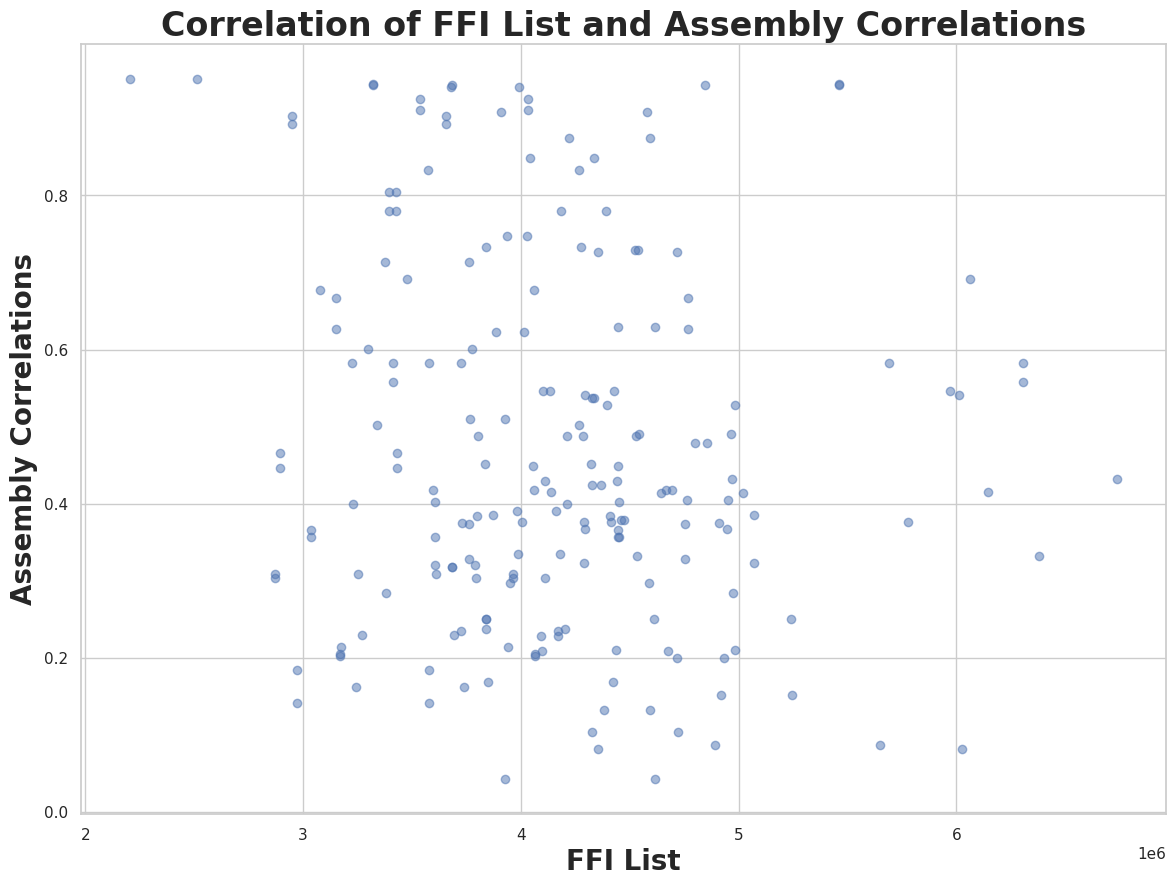

In [46]:
## Correlation of Correlation and Inhibitory Chains
# with open("W_chain_nonzero_pairwise_inhibitory.pkl", "rb") as f:
#     W_chain_nonzero_pairwise_inhibitory = pickle.load(f)

assembly_correlations = np.load('assembly_r_scores.npy')
ffi_array = np.load('assembly_ffi_values.npy')
print(assembly_correlations.shape)
# ffi_array = np.load('FFI_product_assembly_to_assembly_array_nonnormalized.npy')[:, 0:15][0:15, :]
# i_array = np.load('FFI_inhibitory_assembly_to_assembly_array.npy')
# my_array = ffi_array
# print(my_array.shape)
# ffi_list = []
# assembly_correlations = []
# for i in range(my_array.shape[0]-1):
#     for j in range(my_array.shape[1]-1):
#         if i != j:
#             ffi_list.append(my_array[i, j])
#             assembly_correlations.append(stats.pearsonr(assembly_traces[:, i], assembly_traces[:, j])[0])

print(len(ffi_array.flatten()))
print(len(assembly_correlations.flatten()))

# correlate ffi_list and assembly_r_scores
print(stats.pearsonr(ffi_array.flatten(), assembly_correlations.flatten()))

# scatter plot the two lists
plt.figure(figsize=(14, 10))
plt.scatter(ffi_array.flatten(), assembly_correlations.flatten(), alpha=0.5)
plt.xlabel('FFI List', fontsize=20, weight='bold')
plt.ylabel('Assembly Correlations', fontsize=20, weight='bold')
plt.title('Correlation of FFI List and Assembly Correlations', fontsize=24, weight='bold')

[array([ 5.59004826e-01,  3.47483486e-01,  1.17058881e-01,  1.97569875e-01,
        1.88700605e-01,  3.93866416e-01,  2.16807042e-01, -5.71218459e-03,
        2.13254401e-01,  8.44282804e-01,  7.03807230e-01,  8.07150804e-03,
        6.13955094e-01,  4.87333773e-01,  6.07537773e-01,  3.35720745e-01,
        1.33017367e-01,  6.11748393e-01,  5.36628239e-01,  5.14522111e-01,
        2.73282986e-01,  2.57643646e-01,  4.00342692e-01,  2.70882419e-01,
        3.65692685e-01,  3.15560614e-01,  4.31937444e-01,  5.32520631e-01,
        4.74059026e-01,  2.37315083e-01,  2.12240645e-01,  2.44143670e-01,
        4.08425965e-01,  3.83133264e-01,  1.30273342e-01,  1.85920282e-01,
        4.85288872e-01,  3.06900324e-01,  2.63496152e-01,  1.51863268e-01,
        1.93602297e-01,  3.31249478e-01,  3.50918392e-01,  1.40808091e-01,
        1.30377254e-01,  7.70366367e-01,  7.77770028e-01, -5.25659872e-02,
        7.42162158e-01,  6.16952395e-01,  7.36734252e-01,  3.59265006e-01,
       -1.31533151e-02, 

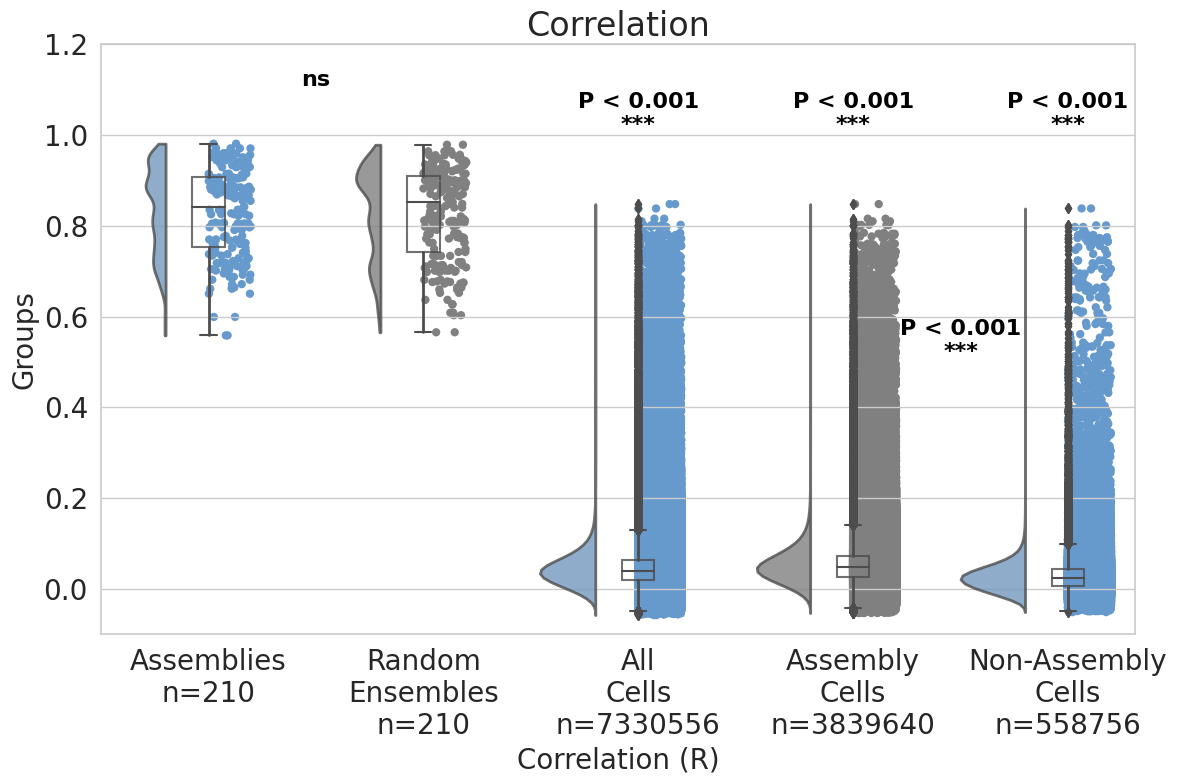

In [ ]:
import ptitprince as pt
# Create a figure
plt.figure(figsize=(12,8))
sns.set_theme(style="whitegrid")

# Prepare data for raincloud plot
print(all_arr)
print(len(assembly_r_scores))
print(len(null_r_scores))
data = pd.DataFrame({
    "Values": np.concatenate((np.array(assembly_r_scores), np.array(null_r_scores))),
    "Group": [f"Assembly\n(n={len(assembly_r_scores)})"] * len(assembly_r_scores) + \
                [f"Null Ensembles\n(n={len(null_r_scores)})"] * len(null_r_scores)
})


# Prepare data for raincloud plot
data = pd.DataFrame({
    "Activity Correlations": np.concatenate((np.array(assembly_r_scores), np.array(null_r_scores), np.array(all_cell_r_scores), np.array(a_cell_r_scores), np.array(no_a_cell_r_scores))),
    "Cell Grouping": [f"Assemblies\nn={len(assembly_r_scores)}"] * len(assembly_r_scores) + \
                [f"Random\nEnsembles\nn={len(null_r_scores)}"] * len(null_r_scores) + \
                [f"All\nCells\nn={len(all_cell_r_scores)}"] * len(all_cell_r_scores) + \
                [f"Assembly\nCells\nn={len(a_cell_r_scores)}"] * len(a_cell_r_scores) + \
                [f"Non-Assembly\nCells\nn={len(no_a_cell_r_scores)}"] * len(no_a_cell_r_scores)
})

# Create the raincloud plot
ax = pt.RainCloud(
    y="Activity Correlations",
    x="Cell Grouping",
    data=data,
    palette=[(.4, .6, .8, .5), 'grey'],
    width_viol=0.6,  # Adjust violin width
    alpha=0.8,  # Transparency of the cloud
    move=0.1,  # Adjust position of violins
    point_size = 6,
    orient="v",  # Horizontal orientation
    linewidth=2
)


# # Calculate p-value
p_value_assembly_null = stats.ranksums(np.array(assembly_r_scores).flatten(), np.array(null_r_scores).flatten(), alternative='two-sided').pvalue
p_value_assembly_all = stats.ranksums(np.array(assembly_r_scores).flatten(), np.array(all_cell_r_scores).flatten(), alternative='two-sided').pvalue
p_value_assembly_a = stats.ranksums(np.array(assembly_r_scores).flatten(), np.array(a_cell_r_scores).flatten(), alternative='two-sided').pvalue
p_value_assembly_no_a = stats.ranksums(np.array(assembly_r_scores).flatten(), np.array(no_a_cell_r_scores).flatten(), alternative='two-sided').pvalue
p_value_a_no_a = stats.ranksums(np.array(a_cell_r_scores).flatten(), np.array(no_a_cell_r_scores).flatten(), alternative='two-sided').pvalue


plt.ylim(-0.1, 1.2)  # Set y-axis limit to [0, 1] for accuracy range

# # Add significance stars
for p_index, p_value in enumerate([p_value_assembly_null, p_value_assembly_all, p_value_assembly_a, p_value_assembly_no_a, p_value_a_no_a]):
    if p_value < 0.001:
        significance = 'P < 0.001\n***'
    elif p_value < 0.01:
        significance = 'P < 0.01\n**'
    elif p_value < 0.05:
        significance = 'P < 0.05\n*'
    else:
        significance = 'ns'

    # Add p-value annotation
    if p_index == 0:
        p_offset = 0.5
        p_height = 1.1
    elif p_index > 0 and p_index < 4:
        p_offset = 1.0 + p_index
        p_height = 1.0
    elif p_index == 4:
        p_offset = 3.5
        p_height = 0.5

    ax.text(p_offset, p_height, f'{significance}', 
                color='black', ha='center', va='bottom', fontsize=16, weight='bold')

# ax.annotate(f'P-Val: {p_value:.3g}', xy=(1, medians[1] + vertical_offset[1]), xytext=(1, medians[1] + vertical_offset[1] + 0.05),
#             arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center', size=18, color='black', weight='semibold')



# Add a multiline title to include the p-value, add y_label
title = f'Correlation'
plt.title(title, size=24)
plt.xlabel('Correlation (R)', size=20)
plt.xticks(fontsize=20)  # Adjust size of xticks
plt.yticks(fontsize=20)  # Adjust size of yticks
plt.ylabel("Groups", size=20)

plt.tight_layout()
plt.savefig('correlations_assemblies_vs_random_ensembles_raincould_plot.png', dpi=1200)
plt.savefig('correlations_assemblies_vs_random_ensembles_raincould_plot.pdf', dpi=1200)
plt.savefig('correlations_assemblies_vs_random_ensembles_raincould_plot.svg', dpi=1200)
plt.show()

In [ ]:
# Compare correlation of asesmblies and random ensembles
# correlate_assembly_traces_vs_random_ensembles(assembly_coactivity_trace, random_ensembles_coactivity_trace, scores_in_order, name='assemblies_vs_ensembles')

In [ ]:
### Step 4: Prepare Decoding Framework in the same way as Assemblies
import v1dd_physiology.data_fetching as daf
nwb_f = h5py.File('M409828_13_20181213.nwb', 'r')

# Get Repeated Natural Movies (11 NATURAL MOVIES SHOWN 9 TIMES)
# trial_fluorescence = []
presentation = nwb_f['stimulus']['presentation']
nm_timestamps = np.array(
    presentation['natural_movie'].get('timestamps'))
nm_data = np.array(presentation['natural_movie'].get('data')) # columns name dataset, gives you the start time, the end time, and the frame number for the natural movie data that was presented
new_clips = np.where(nm_data[:, 2] == 0)[0] # get the index where a new clip rotation begins (frame numbers repeat)
clip_duration = 300  

f = random_ensembles_coactivity_trace
passing_roi_count = f.shape[1] # 15

coactivity_during_movie = np.zeros((passing_roi_count, 300))
results = {}
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))

# Get Repeated Natural Movies
trial_fluorescence = []
presentation = nwb_f['stimulus']['presentation']
nm_timestamps = np.array(
    presentation['natural_movie'].get('timestamps'))
nm_data = np.array(presentation['natural_movie'].get('data'))[:-900] # don't use the last 900 frames, these are the "short" nms which are unrelated
new_clips = np.where(nm_data[:, 2] == 0)[0]
clip_duration = 300  # new_clips[1]-1

clip_ids = []
random_ensemble_coactivity_time_traces = []
start_of_nms = np.where(f_ts > nm_data[0,0])[0][0] # find the frames where the natural movies start to be presented
end_of_nms = np.where(f_ts > nm_data[-1,1])[0][0] # find the frames where the natural movies finish presenting
for time_idx in range(start_of_nms, end_of_nms):
    idx_nm = np.where(nm_data[:,1] > f_ts[time_idx])[0][0] # get the first index
    total_frame_presented = nm_data[idx_nm, 2]
    within_repeats_frame_num = total_frame_presented % 3600
    clip_id = within_repeats_frame_num // 300
    clip_ids.append(clip_id)
    random_ensemble_coactivity_time_traces.append(random_ensembles_coactivity_trace[time_idx,:])

clip_ids = np.array(clip_ids).reshape(-1,1)
random_ensemble_coactivity_time_traces = np.array(random_ensemble_coactivity_time_traces)

print(clip_ids.shape, random_ensemble_coactivity_time_traces.shape)

In [ ]:
# ### Step 5: Run Decoding Metric with Random Ensembles
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score


# # Initialize lists to store accuracy for each neuron
# accuracies = []

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(random_ensemble_coactivity_time_traces, clip_ids, test_size=0.2, random_state=74)

# # Initialize and train the Lasso Regression model
# alpha = 0.1  # Regularization parameter
# lasso_model = Ridge(alpha=alpha)
# lasso_model.fit(X_train, y_train)

# # Make predictions
# predictions = lasso_model.predict(X_test)

# # Round the predictions to the nearest integer to get the decoded clip IDs
# decoded_clip_ids = predictions.round().astype(int)

# # Print out the accuracy
# print("Accuracy Score of", accuracy_score(y_test, decoded_clip_ids))


# # # Create a dataframe to store the results
# # results_df = pd.DataFrame({'Assembly': range(1, num_assemblies + 1), 'Accuracy': accuracies})

# # # Plot the results using Seaborn
# # plt.figure(figsize=(10, 6))
# # sns.barplot(x='Assembly', y='Accuracy', data=results_df, palette='viridis')
# # plt.title('Accuracy of Decoding Natural Movie Clip IDs for Each Assembly')
# # plt.xlabel('Neuron')
# # plt.ylabel('Accuracy')
# # plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for accuracy range
# # plt.show()

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import confusion_matrix

# # split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(random_ensemble_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# # define the model
# clf = RandomForestClassifier(random_state=74)

# # define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # create the grid search object
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)

# # fit the grid search
# grid_search.fit(X_train, y_train)

# # get the best model
# best_clf = grid_search.best_estimator_

# # predict the clip_ids
# y_pred = best_clf.predict(X_test)

# # print out the accuracy
# print("Accuracy Score of", accuracy_score(y_test, y_pred))

# # plot the confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(cm))})
# plt.title("Random Ensemble Clip ID Classification with Random Forrest Classifier", fontsize=16)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

In [ ]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import StandardScaler

# # split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(random_ensemble_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# # scale the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # define the model
# clf = MLPClassifier(random_state=74)

# # define the parameter grid: checked on all and relu provided best score (makes results comparable between assembly and null sets as well)
# param_grid = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (50, 50, 100), (100, 100)],
#     'activation': ['relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
#     'learning_rate': ['constant','adaptive', 'invscaling'],
#     'batch_size': [64, 128, 256, 512, 1024],
#     'max_iter': [500]
# }

# # create the grid search object
# grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)

# # fit the grid search
# grid_search.fit(X_train_scaled, y_train)

# # get the best model
# best_clf = grid_search.best_estimator_

# # predict the clip_ids
# y_pred = best_clf.predict(X_test_scaled)

# # print out the accuracy
# print("Accuracy Score of", accuracy_score(y_test, y_pred))

# # plot the confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(cm))})
# plt.title("Random Ensemble Clip ID Classification with MLPClassifier", fontsize=16)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.savefig('random_ensemble_clip_id_decoder_MLPClassifier.png', dpi = 1200)
# plt.show()

In [ ]:
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)

In [ ]:
# #### Develop normalized Heatmap
# cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plt.figure(figsize=(10,7))
# sns.heatmap(cm_norm, annot=True, vmax = 1, fmt=".3f", annot_kws={"size": 35 / np.sqrt(len(cm))})
# plt.title("Random Ensemble Clip ID Classification Percentage with MLPClassifier", fontsize=16)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.savefig('random_ensemble_clip_id_percentage_decoder_MLPClassifier.png', dpi = 1200)
# plt.show()

### Reproduce with Balanced Clip IDs

In [ ]:
clip_ids.shape, assembly_coactivity_time_traces.shape

In [ ]:
# Get unique clip_ids and their counts
unique_clip_ids, counts = np.unique(clip_ids, return_counts=True)

# Determine the minimum count of any clip_id
min_count = np.min(counts)

# Create new lists for balanced clip_ids and corresponding assembly_coactivations
balanced_clip_ids = []
balanced_assembly_coactivations = []

# Sample min_count indices for each clip_id
for clip_id in unique_clip_ids:
    # Get indices of the current clip_id
    indices = np.where(clip_ids == clip_id)[0]
    # Randomly sample min_count indices
    np.random.seed(747)
    sampled_indices = np.random.choice(indices, min_count, replace=False)
    # Append the sampled indices' values to the new lists
    balanced_clip_ids.extend(clip_ids[sampled_indices])
    balanced_assembly_coactivations.extend(assembly_coactivity_time_traces[sampled_indices])

# Convert lists to numpy arrays
balanced_clip_ids = np.array(balanced_clip_ids)
balanced_assembly_coactivations = np.array(balanced_assembly_coactivations)

# Shuffle to ensure random distribution
shuffled_indices = np.random.default_rng(seed=747).permutation(len(balanced_clip_ids))
balanced_clip_ids = balanced_clip_ids[shuffled_indices]
balanced_assembly_coactivations = balanced_assembly_coactivations[shuffled_indices]

# Output the balanced arrays
print("Balanced clip_ids:", balanced_clip_ids)
print("Balanced assembly_coactivations:", balanced_assembly_coactivations)

In [ ]:
balanced_clip_ids.shape, balanced_assembly_coactivations.shape

In [ ]:
plt.hist(balanced_clip_ids)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_assembly_coactivations, balanced_clip_ids.ravel(), test_size=0.2, random_state=747)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define the model
clf = MLPClassifier(random_state=747)

# define the parameter grid: checked on all and relu provided best score (makes results comparable between assembly and null sets as well)
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (50, 50, 100), (100, 100)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'batch_size': [64, 128, 256, 512, 1024],
    'max_iter': [500]
}

# create the grid search object
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)

# fit the grid search
grid_search.fit(X_train_scaled, y_train)

# get the best model
best_clf = grid_search.best_estimator_

# predict the clip_ids
y_pred = best_clf.predict(X_test_scaled)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))

# plot the confusion matrix
assembly_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(assembly_cm, annot=True, vmax = 100, annot_kws={"size": 40 / np.sqrt(len(assembly_cm))})
plt.title("Assembly Balanced Clip ID Classification with MLPClassifier", fontsize=24)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Truth', fontsize=16)
plt.ylabel(rotation=0)
plt.savefig('assembly_balanced_clip_id_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

In [ ]:
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)

In [ ]:
#### Develop normalized Heatmap
assembly_cm_norm = assembly_cm.astype('float') / assembly_cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12,8))
sns.heatmap(assembly_cm_norm*100, annot=True, vmax = 1, fmt=".2f", annot_kws={"size": 40 / np.sqrt(len(assembly_cm))})
plt.title("Assembly Balanced Clip ID Classification Percentage with MLPClassifier", fontsize=24)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Truth', fontsize=16)
plt.yticks(rotation=0) 
plt.savefig('assembly_balanced_clip_id_percentage_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

In [ ]:
print(clip_ids.shape, random_ensemble_coactivity_time_traces.shape)

# Get unique clip_ids and their counts
unique_clip_ids, counts = np.unique(clip_ids, return_counts=True)

# Determine the minimum count of any clip_id
min_count = np.min(counts)

# Create new lists for balanced clip_ids and corresponding assembly_coactivations
balanced_clip_ids = []
balanced_random_ensemble_coactivations = []

# Sample min_count indices for each clip_id
for clip_id in unique_clip_ids:
    # Get indices of the current clip_id
    indices = np.where(clip_ids == clip_id)[0]
    # Randomly sample min_count indices
    np.random.seed(747)
    sampled_indices = np.random.choice(indices, min_count, replace=False)
    # Append the sampled indices' values to the new lists
    balanced_clip_ids.extend(clip_ids[sampled_indices])
    balanced_random_ensemble_coactivations.extend(random_ensemble_coactivity_time_traces[sampled_indices])

# Convert lists to numpy arrays
balanced_clip_ids = np.array(balanced_clip_ids)
balanced_random_ensemble_coactivations = np.array(balanced_random_ensemble_coactivations)

# Shuffle to ensure random distribution
shuffled_indices = np.random.default_rng(seed=747).permutation(len(balanced_clip_ids))
balanced_clip_ids = balanced_clip_ids[shuffled_indices]
balanced_random_ensemble_coactivations = balanced_random_ensemble_coactivations[shuffled_indices]

# Output the balanced arrays
print("Balanced clip_ids:", balanced_clip_ids)
print("Balanced random_ensemble_coactivations:", balanced_random_ensemble_coactivations)

In [ ]:
balanced_clip_ids.shape, balanced_random_ensemble_coactivations.shape

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_random_ensemble_coactivations, balanced_clip_ids.ravel(), test_size=0.2, random_state=747)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define the model
clf = MLPClassifier(random_state=747)

# define the parameter grid: checked on all and relu provided best score (makes results comparable between assembly and null sets as well)
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (50, 50, 100), (100, 100)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'batch_size': [64, 128, 256, 512, 1024],
    'max_iter': [500]
}

# create the grid search object
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)

# fit the grid search
grid_search.fit(X_train_scaled, y_train)

# get the best model
best_clf = grid_search.best_estimator_

# predict the clip_ids
y_pred = best_clf.predict(X_test_scaled)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))

# plot the confusion matrix
rand_ensemble_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(rand_ensemble_cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(rand_ensemble_cm))})
plt.title("Random Ensemble Balanced Clip ID Classification with MLPClassifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.yticks(rotation=0)
plt.savefig('random_ensemble_balanced_clip_id_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

In [ ]:
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)

In [ ]:
#### Develop normalized Heatmap
rand_ensemble_cm_norm = rand_ensemble_cm.astype('float') / rand_ensemble_cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,7))
sns.heatmap(rand_ensemble_cm_norm*100, annot=True, vmax = 1, fmt=".2f", annot_kws={"size": 35 / np.sqrt(len(rand_ensemble_cm))})
plt.title("Random Ensemble Balanced Clip ID Classification Percentage with MLPClassifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.yticks(rotation=0)
plt.savefig('random_ensemble_balanced_clip_id_percentage_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

In [ ]:
### Produce Statistical Test Between Two Heatmaps
assembly_cm_norm_mean = np.mean(assembly_cm_norm.flatten())
assembly_cm_norm_std = np.std(assembly_cm_norm.flatten())
rand_ensemble_cm_mean = np.mean(rand_ensemble_cm_norm.flatten())
rand_ensemble_cm_std = np.std(rand_ensemble_cm_norm.flatten())
print(f"Assembly Heatmap: Mean = {assembly_cm_norm_mean}, Std = {assembly_cm_norm_std}")
print(f"Random Ensemble Heatmap: Mean = {rand_ensemble_cm_mean}, Std = {rand_ensemble_cm_std}")

# Mann-Whitney U test
mw_u_stat, mw_p_value = stats.mannwhitneyu(assembly_cm_norm.flatten(), rand_ensemble_cm_norm.flatten())
print(f"Mann-Whitney U test: u_stat = {mw_u_stat}, p_value = {mw_p_value}")

# Rank-biserial correlation
rank_biserial = 1 - 2 * mw_u_stat / (len(assembly_cm_norm.flatten()) * len(rand_ensemble_cm_norm.flatten()))
print(f"Mann-Whitney U Test Rank-biserial correlation = {rank_biserial}")

# Wilcoxon rank-sum
wrs_stat, wrs_p_value = stats.ranksums(assembly_cm_norm.flatten(), rand_ensemble_cm_norm.flatten())
print(f"Wilcoxon Rank-Sum U test: u_stat = {wrs_stat}, p_value = {wrs_p_value}")

In [ ]:
### Statistical test of just the Diagonal, Implying Accuracy
assembly_accuracy = np.diag(assembly_cm_norm)
rand_ensemble_accuracy = np.diag(rand_ensemble_cm_norm)

assembly_accuracy_mean = np.mean(assembly_accuracy)
assembly_accuracy_std = np.std(assembly_accuracy)
rand_ensemble_accuracy_mean = np.mean(rand_ensemble_accuracy)
rand_ensemble_accuracy_std = np.std(rand_ensemble_accuracy)
print(f"Assembly Heatmap: Mean = {assembly_accuracy_mean}, Std = {assembly_accuracy_std}")
print(f"Random Ensemble Heatmap: Mean = {rand_ensemble_accuracy_mean}, Std = {rand_ensemble_cm_std}")

# Mann-Whitney U test
mw_u_stat, mw_p_value = stats.mannwhitneyu(assembly_accuracy, rand_ensemble_accuracy, alternative = 'greater')
print(f"Mann-Whitney U test: u_stat = {mw_u_stat}, p_value = {mw_p_value}")

# Rank-biserial correlation
rank_biserial = 1 - 2 * mw_u_stat / (len(assembly_accuracy) * len(rand_ensemble_accuracy))
print(f"Mann-Whitney U Test Rank-biserial correlation = {rank_biserial}")

# Wilcoxon rank-sum
wrs_stat, wrs_p_value = stats.ranksums(assembly_accuracy, rand_ensemble_accuracy, alternative = 'greater')
print(f"Wilcoxon Rank-Sum U test: u_stat = {wrs_stat}, p_value = {wrs_p_value}")

### Reproduce Oracle Score Analysis with Random Ensembles

In [ ]:
pika_rois_all_dict = {}
pika_rois_in_assembly_dict = {}
pika_rois_no_assembly_dict = {}
for plane_n, roi_ns in rois_dict.items():
    pika_rois = []
    pika_rois_in_assembly = []
    pika_rois_no_assembly = []
    # print(plane_n)
    for roi_n in roi_ns:
        score = daf.get_pika_classifier_score(nwb_f=nwb_f, plane_n=plane_n, roi_n=roi_n)
        if score > 0.5:  # Using the threshold from team PIKA, per https://github.com/zhuangjun1981/v1dd_physiology/blob/main/v1dd_physiology/example_notebooks/2022-06-27-data-fetching-basic.ipynb
            pika_rois.append(roi_n)
            if int(roi_n[4:]) in assembly_neurons:
                pika_rois_in_assembly.append(roi_n)
            else:
                pika_rois_no_assembly.append(roi_n)
    pika_rois_all_dict[plane_n] = pika_rois
    pika_rois_in_assembly_dict[plane_n] = pika_rois_in_assembly
    pika_rois_no_assembly_dict[plane_n] = pika_rois_no_assembly

total_rois = np.sum([len(val) for val in pika_rois_all_dict.values()])
neuron_all_movie_oracle_r_values = np.zeros((total_rois, 9))

total_rois = np.sum([len(val) for val in pika_rois_in_assembly_dict.values()])
neuron_in_assembly_movie_oracle_r_values = np.zeros((total_rois, 9))

total_rois = np.sum([len(val) for val in pika_rois_no_assembly_dict.values()])
neuron_no_assembly_movie_oracle_r_values = np.zeros((total_rois, 9))

count_n_all = -1
count_n_in_assembly = -1
count_n_no_assembly = -1
for curr_dict, oracle_array, c in zip([pika_rois_all_dict, pika_rois_in_assembly_dict, pika_rois_no_assembly_dict], 
        [neuron_all_movie_oracle_r_values, neuron_in_assembly_movie_oracle_r_values, neuron_no_assembly_movie_oracle_r_values],
        [1,2,3]):
    for plane_n, pika_roi_ns in curr_dict.items():
        for roi_n in pika_roi_ns:
            if c == 1:
                count_n_all += 1
                current_count = count_n_all
            elif c == 2:
                count_n_in_assembly += 1
                current_count = count_n_in_assembly
            elif c == 3:
                count_n_no_assembly += 1
                current_count = count_n_no_assembly
            ### Get Time Trace
            dff, dff_ts = daf.get_single_trace(nwb_f=nwb_f, plane_n=plane_n, roi_n=roi_n, trace_type='dff')

            # Get Repeated Natural Movies
            trial_fluorescence = []
            presentation = nwb_f['stimulus']['presentation']
            nm_timestamps = np.array(
                presentation['natural_movie'].get('timestamps'))
            nm_data = np.array(presentation['natural_movie'].get('data'))
            new_clips = np.where(nm_data[:, 2] == 0)[0]
            clip_duration = 300  # new_clips[1]-1
            for repeat_id in range(new_clips.shape[0]):
                frames_to_capture = np.where(dff_ts >= nm_timestamps[new_clips[repeat_id]])[
                    0][0:clip_duration]
                trial_fluorescence.append(dff[frames_to_capture])
            trial_fluorescence_np = np.array(trial_fluorescence)
            for trial_idx in range(trial_fluorescence_np.shape[0]):
                removed_trial = trial_fluorescence_np[trial_idx]
                remaining_trials = np.delete(
                    trial_fluorescence_np, trial_idx, 0)
                r, p = scipy.stats.pearsonr(
                    removed_trial, np.mean(remaining_trials, 0))
                oracle_array[current_count, trial_idx] = r

assembly_movie_oracle_r_values = np.zeros((passing_roi_count, 9))
f = assembly_coactivity_trace
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))
for roi_n in range(passing_roi_count):

    # Get Repeated Natural Movies
    trial_fluorescence = []
    presentation = nwb_f['stimulus']['presentation']
    nm_timestamps = np.array(
        presentation['natural_movie'].get('timestamps'))
    nm_data = np.array(presentation['natural_movie'].get('data'))
    new_clips = np.where(nm_data[:, 2] == 0)[0]
    clip_duration = 300  # new_clips[1]-1
    for repeat_id in range(new_clips.shape[0]):
        frames_to_capture = np.where(f_ts >= nm_timestamps[new_clips[repeat_id]])[
            0][0:clip_duration]
        trial_fluorescence.append(f[frames_to_capture, roi_n])
    trial_fluorescence_np = np.array(trial_fluorescence)
    for trial_idx in range(trial_fluorescence_np.shape[0]):
        removed_trial = trial_fluorescence_np[trial_idx]
        remaining_trials = np.delete(
            trial_fluorescence_np, trial_idx, 0)
        r, p = scipy.stats.pearsonr(
            removed_trial, np.mean(remaining_trials, 0))
        assembly_movie_oracle_r_values[roi_n, trial_idx] = r

# Plot Movie Oracles
mean_over_holdouts = np.mean(assembly_movie_oracle_r_values, 1)
fig = plt.figure()
plt.title('Assembly natural movie oracle score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.hist(mean_over_holdouts[:], bins=50)
#plt.savefig('oracle_dists2/assemblies_esteps_150000__affinity_04_session'+str(13)+'_movies.png')
plt.show()

random_ensemble_movie_oracle_r_values = np.zeros((passing_roi_count, 9))
f = random_ensembles_coactivity_trace
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))
for roi_n in range(passing_roi_count):

    # Get Repeated Natural Movies
    trial_fluorescence = []
    presentation = nwb_f['stimulus']['presentation']
    nm_timestamps = np.array(
        presentation['natural_movie'].get('timestamps'))
    nm_data = np.array(presentation['natural_movie'].get('data'))
    new_clips = np.where(nm_data[:, 2] == 0)[0]
    clip_duration = 300  # new_clips[1]-1
    for repeat_id in range(new_clips.shape[0]):
        frames_to_capture = np.where(f_ts >= nm_timestamps[new_clips[repeat_id]])[
            0][0:clip_duration]
        trial_fluorescence.append(f[frames_to_capture, roi_n])
    trial_fluorescence_np = np.array(trial_fluorescence)
    for trial_idx in range(trial_fluorescence_np.shape[0]):
        removed_trial = trial_fluorescence_np[trial_idx]
        remaining_trials = np.delete(
            trial_fluorescence_np, trial_idx, 0)
        r, p = scipy.stats.pearsonr(
            removed_trial, np.mean(remaining_trials, 0))
        random_ensemble_movie_oracle_r_values[roi_n, trial_idx] = r

import ptitprince as pt
# Plot Movie Oracles
mean_over_holdouts = np.mean(random_ensemble_movie_oracle_r_values, 1)
fig = plt.figure()
plt.title('Random Ensemble natural movie oracle score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.hist(mean_over_holdouts[:], bins=50)
#plt.savefig('oracle_dists2/assemblies_esteps_150000__affinity_04_session'+str(13)+'_movies.png')
plt.show()

# Create a figure
plt.figure(figsize=(10,7))
sns.set_theme(style="whitegrid")

# Prepare data for raincloud plot
data = pd.DataFrame({
    "Values": np.concatenate(all_arr),
    "Group": [f"Assemblies"] * len(assembly_movie_oracle_r_values.flatten()) + \
                [f"Random\nEnsembles"] * len(random_ensemble_movie_oracle_r_values.flatten()) + \
                [f"All\nCells"] * len(neuron_all_movie_oracle_r_values.flatten()) + \
                [f"Assembly\nCells"] * len(neuron_in_assembly_movie_oracle_r_values.flatten()) + \
                [f"Non-Assembly\nCells"] * len(neuron_no_assembly_movie_oracle_r_values.flatten())
})

# Create the raincloud plot
ax = pt.RainCloud(
    y="Values",
    x="Group",
    data=data,
    palette=[(.4, .6, .8, .5), 'grey'],
    width_viol=0.6,  # Adjust violin width
    alpha=0.8,  # Transparency of the cloud
    move=0.1,  # Adjust position of violins
    point_size = 4,
    orient="v"  # Horizontal orientation
)

plt.ylim(-0.2, 1.2)

# Calculate p-values for Wilcoxon rank-sum tests
groups = ["Random\nEnsembles", "All\nCells", "Assembly\nCells", "Non-Assembly\nCells"]
p_values = []
for group in groups:
    group_values = data[data["Group"] == group]["Values"]
    p_value = stats.ranksums(data[data["Group"] == "Assemblies"]["Values"], group_values, alternative='greater').pvalue
    p_values.append(p_value)

# Add significance markers as number of asterisks
for i, p_value in enumerate(p_values):
    if p_value < 0.001:
        significance = 'p < 0.001\n***'
    elif p_value < 0.01:
        significance = 'p < 0.01\n**'
    elif p_value < 0.05:
        significance = 'p < 0.05\n*'
    else:
        significance = ''
    ax.annotate(significance, xy=(i + 1, data[data["Group"] == groups[i]]["Values"].max() + 0.1),
                horizontalalignment='center', size=16, color='black', weight='bold')



# Add a multiline title to include the p-value, add y_label
title = f'Natural Movie Oracle Scores'
plt.title(title, size=24)
# plt.xlabel('Cell Grouping', size=20)
plt.xticks(fontsize=20)  # Adjust size of xticks
plt.yticks(fontsize=20)  # Adjust size of yticks
plt.ylabel("Oracle Score", size=20)

plt.tight_layout()
plt.savefig('oracle_scores_histogram_dff_all_sets_violin.png', dpi = 1200)
plt.savefig('oracle_scores_histogram_dff_all_sets_violin.pdf')
plt.savefig('oracle_scores_histogram_dff_all_sets_violin.svg')
plt.show()

# all_arr = [np.array(assembly_movie_oracle_r_values).flatten(),
#             np.array(random_ensemble_movie_oracle_r_values).flatten(),
#             np.array(neuron_all_movie_oracle_r_values).flatten(),
#             np.array(neuron_in_assembly_movie_oracle_r_values).flatten(),
#             np.array(neuron_no_assembly_movie_oracle_r_values).flatten()]
# sns.set_theme(style="whitegrid")
# ax = sns.boxplot(data=all_arr,
#                 notch=True, showcaps=True,
#                 flierprops={"marker": "x"},
#                 boxprops={"facecolor": (.4, .6, .8, .5)},
#                 medianprops={"color": "coral"},
#             )
# ax.set_xticklabels(["Assemblies", "Random Ensembles", "All Cells", "Assembly Cells", "Non-Assembly Cells"], size = 14)
# ax.set_title('Natural Movie Oracle Score', size = 20)
# ax.set_ylabel('Oracle Score', size = 15)

# medians = np.array(
#     [np.median(np.array(assembly_movie_oracle_r_values).flatten()),
#      np.median(np.array(random_ensemble_movie_oracle_r_values).flatten()),
#      np.median(np.array(neuron_all_movie_oracle_r_values).flatten()),
#      np.median(np.array(neuron_in_assembly_movie_oracle_r_values).flatten()),
#      np.median(np.array(neuron_no_assembly_movie_oracle_r_values).flatten())]
# )

# vertical_offset = medians * 0.2 # offset from median for display
# p_values = [np.nan,
#             'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(random_ensemble_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
#             'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_all_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
#             'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_in_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
#             'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5)]

# for xtick in ax.get_xticks():
#     if xtick != 0:
#         ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick], 
#                 horizontalalignment='center', size='small', color='black', weight='semibold')

# plt.savefig('oracle_scores_histogram_dff_all_sets.png', dpi = 1200)
# plt.show()

In [ ]:
# Plot Movie Oracles
plt.figure(figsize=(14, 10))

all_arr = [np.array(assembly_movie_oracle_r_values).flatten(),
            np.array(random_ensemble_movie_oracle_r_values).flatten(),
            np.array(neuron_all_movie_oracle_r_values).flatten(),
            np.array(neuron_in_assembly_movie_oracle_r_values).flatten(),
            np.array(neuron_no_assembly_movie_oracle_r_values).flatten()]
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=all_arr,
                notch=True, showcaps=True,
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.4, .6, .8, .5)},
                medianprops={"color": "coral"},
            )
ax.set_xticklabels(["Assemblies", "Random Ensembles", "All Cells", "Assembly Cells", "Non-Assembly Cells"], size = 15)
ax.set_title('Natural Movie Oracle Score', size = 20)
ax.set_ylabel('Oracle Score', size = 16)
plt.yticks(fontsize=15)

medians = np.array(
    [np.median(np.array(assembly_movie_oracle_r_values).flatten()),
     np.median(np.array(random_ensemble_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_all_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_in_assembly_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_no_assembly_movie_oracle_r_values).flatten())]
)

vertical_offset = medians * 0.15 # offset from median for display
p_values = [np.nan,
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(random_ensemble_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_all_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_in_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5)]

for xtick in ax.get_xticks():
    if xtick != 0:
        ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick], 
                horizontalalignment='center', size= 12, color='black', weight='semibold')

plt.savefig('oracle_scores_histogram_dff_all_sets.png', dpi = 1200)
plt.show()

wrs_p_value = stats.ranksums(np.array(neuron_all_movie_oracle_r_values).flatten(), np.array(neuron_in_assembly_movie_oracle_r_values).flatten())
print(f"Rank-Sum (All Cells vs Assembly Cells): p_value = {wrs_p_value}")
wrs_p_value = stats.ranksums(np.array(neuron_all_movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten())
print(f"Rank-Sum (All Cells vs Non-Assembly Cells): p_value = {wrs_p_value}")
wrs_p_value = stats.ranksums(np.array(neuron_in_assembly_movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten())
print(f"Rank-Sum (Assembly Cells vs Non-Assembly Cells): p_value = {wrs_p_value}")

### Reproduce Sparsity Plot with Random Ensembles

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_ginis(coactivity_trace, null_trace=None, all_trace=None, a_trace=None, no_a_trace=None):
    num_assemblies = coactivity_trace.shape[1]
    gini_values = [gini(coactivity_trace[:,i]) for i in range(num_assemblies)]
    labels = [f'A {i+1}' for i in range(num_assemblies)]
    
    if no_a_trace is not None:
        gini_values_no_a = [gini(no_a_trace[:,i]) for i in range(no_a_trace.shape[1])]
        mean_gini_no_a = np.nanmean(gini_values_no_a)
        # labels.insert(0, 'Nonassembly\nCells')
    
    if a_trace is not None:
        gini_values_a = [gini(a_trace[:,i]) for i in range(a_trace.shape[1])]
        mean_gini_a = np.nanmean(gini_values_a)
        # labels.insert(0, 'Assembly\nCells')
    
    # if all_trace is not None:
    #     gini_values_all = [gini(all_trace[:,i]) for i in range(all_trace.shape[1])]
    #     mean_gini_all = np.nanmean(gini_values_all)
    #     labels.insert(0, 'All\nCells')
    
    if null_trace is not None:
        gini_values_null = [gini(null_trace[:,i]) for i in range(num_assemblies)]
        mean_gini_null = np.nanmean(gini_values_null)
        # labels.insert(0, 'Null')
        
    print(gini_values)
    print(gini_values_null)
    print(labels)

    # Create a DataFrame for the grouped bar plot
    gini_df = pd.DataFrame({
        'Assembly Gini Values': gini_values,
        'Random Ensemble Gini Values': gini_values_null,
        'Labels': labels
    })

    # print(gini_df)

    # Melt the DataFrame to long format
    gini_df_melted = gini_df.melt(id_vars='Labels', value_vars=['Assembly Gini Values', 'Random Ensemble Gini Values'], 
                                  var_name='Type', value_name='Gini Coefficient')

    p_value = stats.ranksums(np.array(gini_values_null).flatten(), np.array(gini_values).flatten(), alternative='less').pvalue

    # Create a grouped bar plot
    plt.figure(figsize=(24, 16))
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x='Labels', y='Gini Coefficient', hue='Type', data=gini_df_melted, palette='Paired')
    ax.set_title(f'Sparsity of Activity\np={p_value}', size=32, weight='bold')
    plt.yticks(fontsize=24, weight='bold')
    plt.xticks(fontsize=24, rotation=45, weight='bold')
    ax.set_ylabel('Gini Coefficient', size=24, weight='bold')
    ax.set_xlabel('Assembly or Equivalent Random Ensemble', size=24, weight='bold')
    plt.ylim((0, 1.0))

    # Add horizontal lines for mean_gini_a and mean_gini_no_a
    if a_trace is not None:
        ax.axhline(mean_gini_a, color='cornflowerblue', linestyle='--', linewidth=2)
        ax.text(len(labels)-3.35, mean_gini_a-0.06, f'Assembly Cells Mean: {mean_gini_a:.3f}', 
                color='cornflowerblue', ha='left', va='bottom', fontsize=20, weight='bold')

    if no_a_trace is not None:
        ax.axhline(mean_gini_no_a, color='slategray', linestyle='--', linewidth=2)
        ax.text(len(labels)-3.35, mean_gini_no_a, f'Nonassembly Cells Mean: {mean_gini_no_a:.3f}', 
                color='slategray', ha='left', va='bottom', fontsize=20, weight='bold')

    # Add annotations for clarity (optional)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 12), textcoords='offset points', size=14, weight='bold')

    plt.legend(bbox_to_anchor=(0, 1.065), loc='upper left', frameon=True, fontsize=20)
    # plt.legend(, loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.savefig('sparsity_with_Gini_coefficient_by_assembly_and_random_ensembles.png')
    plt.savefig('sparsity_with_Gini_coefficient_by_assembly_and_random_ensembles.pdf')
    plt.savefig('sparsity_with_Gini_coefficient_by_assembly_and_random_ensembles.svg')

    # gini_values_all = gini_values_a + gini_values_no_a
    
    # # Create a figure
    # plt.figure(figsize=(24,8))
    # sns.set_theme(style="whitegrid")

    # all_arr = [np.array(gini_values).flatten(),
    #         np.array(gini_values_null).flatten(),
    #         np.array(gini_values_all).flatten(),
    #         np.array(gini_values_a).flatten(),
    #         np.array(gini_values_no_a).flatten()]

    # print(np.min(gini_values))
    # print(np.max(gini_values))
    # print(np.min(gini_values_all))
    # print(np.max(gini_values_all))
    # print(np.min(gini_values_a))
    # print(np.max(gini_values_a))
    # print(np.min(gini_values_no_a))
    # print(np.max(gini_values_no_a))

    # # Prepare data for raincloud plot
    # data = pd.DataFrame({
    #     "Gini Coefficients": np.concatenate(all_arr),
    #     "Cell Grouping": [f"Assemblies\nn={len(gini_values)}"] * len(gini_values) + \
    #                 [f"Random\nEnsembles\nn={len(gini_values_null)}"] * len(gini_values_null) + \
    #                 [f"All\nCells\nn={len(gini_values_all)}"] * len(gini_values_all) + \
    #                 [f"Assembly\nCells\nn={len(gini_values_a)}"] * len(gini_values_a) + \
    #                 [f"Non-Assembly\nCells\nn={len(gini_values_no_a)}"] * len(gini_values_no_a)
    # })

    # # Create the raincloud plot
    # ax = pt.RainCloud(
    #     y="Gini Coefficients",
    #     x="Cell Grouping",
    #     data=data,
    #     palette=[(.4, .6, .8, .5), 'grey'],
    #     width_viol=0.6,  # Adjust violin width
    #     alpha=0.8,  # Transparency of the cloud
    #     move=0.1,  # Adjust position of violins
    #     point_size = 6,
    #     orient="v",  # Horizontal orientation
    #     linewidth=2
    # )

    
    #  # # Calculate p-value
    # p_value = stats.ranksums(np.array(gini_values_null).flatten(), np.array(gini_values).flatten(), alternative='less').pvalue

    # # # Add significance stars
    # if p_value < 0.001:
    #     significance = 'P < 0.001\n***'
    # elif p_value < 0.01:
    #     significance = 'P < 0.01\n**'
    # elif p_value < 0.05:
    #     significance = 'P < 0.05\n*'
    # else:
    #     significance = 'ns'

    # # Add p-value annotation

    # ax.text(0.5, 0.9, f'{significance}', 
    #             color='black', ha='center', va='bottom', fontsize=20, weight='bold')
    
    # ax.annotate(f'P-Val: {p_value:.3g}', xy=(1, medians[1] + vertical_offset[1]), xytext=(1, medians[1] + vertical_offset[1] + 0.05),
    #             arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center', size=18, color='black', weight='semibold')

    

    # plt.ylabel('Gini Coefficient', size=20, weight='bold')
    # plt.xticks(fontsize=20, weight='bold')
    # plt.yticks(fontsize=20, weight='bold')
    # # plt.xlabel("Groups", size=20, weight='bold')

    # plt.tight_layout()
    # plt.savefig('gini_coefficients_raincloud_plot.png', dpi=1200)
    # plt.savefig('gini_coefficients_raincloud_plot.pdf', dpi=1200)
    # plt.savefig('gini_coefficients_raincloud_plot.svg', dpi=1200)
    # plt.show()

In [ ]:
print(activity_raster.shape)
print(np.min(no_assembly_neurons))
print(np.min(assembly_neurons))
plot_ginis(coactivity_trace=assembly_coactivity_trace, null_trace=random_ensembles_coactivity_trace, all_trace=activity_raster, a_trace=activity_raster[:,assembly_neurons], no_a_trace=activity_raster[:,no_assembly_neurons])